In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az

Bad val "cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])" on line #240
	"axes.prop_cycle    : cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])  # color cycle for plot lines
"
	in file "C:\Users\zhaolei\.matplotlib\matplotlibrc"
	Key axes.prop_cycle: 'cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])' is not a valid cycler construction: invalid syntax (<string>, line 1)


In [2]:
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

混合以前的现有元素是创建新内容的绝妙方法，不仅是音乐。 在统计中，混合模型是建立模型的一种常用方法。 通过混合更简单的分布以获得更复杂的分布来构建这些模型。 例如，我们可以结合两个高斯来描述双峰分布，也可以结合许多高斯来描述任意分布。 尽管使用高斯很普遍，但原则上我们可以混合我们想要的任何分布族。 混合物模型用于不同的目的，例如直接对子种群建模或作为处理复杂分布的有用技巧，而这些分布不能用更简单的分布来描述。

在本章中，我们将涵盖以下主题：
有限混合模型
无限混合模型
连续混合模型

## Mixture models
当总人口是不同亚群的组合时，自然会产生混合模型。 一个非常熟悉的例子是给定成年人口的身高分布，这可以描述为女性和男性亚人群的混合。 另一个经典的例子是手写数字的聚类。 在这种情况下，至少在以10为基数的系统中预期10个子种群是非常合理的！ 如果我们知道每个观测值属于哪个子种群，通常最好使用该信息将每个子种群建模为一个单独的组。 但是，当我们无法直接访问此信息时，就可以使用混合模型（使用单个概率分布无法正确描述许多数据集，但可以将它们描述为这些分布的混合。 假设数据来自混合分布的模型称为混合模型。）

在构建混合模型时，并不一定要相信我们在描述数据中的真实子种群。混合物模型也可以用作统计技巧，以增加我们工具箱的灵活性。以高斯分布为例。我们可以将其用作许多单峰分布或多或少对称分布的合理近似。但是多峰或偏态分布呢？我们可以使用高斯分布对其建模吗？是的，如果我们混合使用高斯，就可以。在高斯混合模型中，每个分量都是具有不同平均值且通常（但不一定）具有不同标准偏差的高斯。通过组合高斯函数，我们可以为模型增加灵活性，以适应复杂的数据分布。实际上，通过使用高斯的适当组合，我们可以近似所需的任何分布。分布的确切数量将取决于近似的准确性和数据的详细信息。实际上，我们在本书的许多情节中都一直采用混合高斯的思想。内核密度估计（KDE）技术是此思想的非贝叶斯（非参数）实现。从概念上讲，当我们称为az时。 plot_kde，该函数在每个数据点的顶部放置一个高斯（具有固定的方差），然后对所有单个高斯进行求和以近似数据的经验分布。图6.1展示了一个实际示例，说明如何混合八个高斯来表示复杂的分布，例如大蟒蛇消化一头大象（如果没有参考文献，我强烈建议您获得本书的副本《小王子》） 。在图6.1中，所有高斯变量都具有相同的方差，并且它们以橙色点为中心，橙色点表示来自可能未知种群的采样点。如果仔细查看图6.1，您可能会注意到其中两个高斯人基本上是一个在另一个之上：

![title](6_1.jpg)

无论我们是真的相信子种群，还是为了数学上的方便（甚至是中间事物）而使用子种群，混合模型都是通过使用分布的混合物来描述数据来增加模型灵活性的有用方法。

## Finite mixture models
建立混合模型的一种方法是考虑两个或多个分布的有限加权混合。 这被称为有限混合模型。 因此，观察到的数据的概率密度是该数据的k个子组的概率密度的加权和：

![title](6_2.jpg)

在此，Wi是每个组件（或类）的权重。我们可以将Wi解释为分量i的概率，因此其值限于区间[0，1]和$\sum_{i=1}^kw_i=1$。分量$ p_i（y | \theta_i）$实际上可以是我们认为有用的任何东西，从简单的分布（例如高斯或泊松）到更复杂的对象（例如层次模型或神经网络）。对于有限混合模型，是一个有限数（通常，但不是必需，一个小数k <= 20）。为了拟合有限混合模型，我们需要提供k值，或者是因为我们事先确实知道正确的值，或者是因为我们有一些有根据的猜测。
从概念上讲，要解决混合模型，我们要做的就是将每个数据点正确分配给组件之一。在概率模型中，我们可以通过引入随机变量来做到这一点，该变量的功能是指定将特定观察值分配给哪个组件。该变量通常称为潜在变量。我们称它为潜伏是因为它不是直接可观察到的。

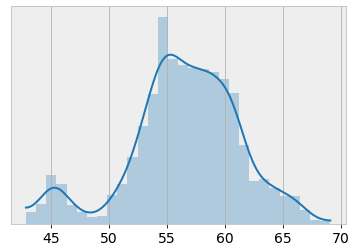

In [2]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])
plt.savefig('B11197_06_02.png')

In [5]:
cs 

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64
...,...,...,...,...
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36


从图6.2中可以看出，使用单个高斯无法正确描述此数据，但也许三个或四个就可以解决问题。 实际上，有很好的理论理由，我们在这里不做讨论，这表明数据确实来自大约40个子种群的混合，但它们之间有相当大的重叠。

为了发展混合模型背后的直觉，我们可以从抛硬币问题中得到一些想法。 对于该模型，我们有两种可能的结果，我们使用伯努利分布来描述它们。 由于我们不知道出现正面或反面的可能性，因此我们将Beta分布用作先验分布。 混合模型是相似的，除了我们现在有了结果（或k分量），而不是像头或尾这样的两个结果。 伯努利分布到k结果的一般化是分类分布，而贝塔利分布的一般化是Dirichlet分布。 因此，让我介绍这两个新的分布。

## The categorical distribution
分类分布是最通用的离散分布，并使用指定每个可能结果概率的参数进行参数化。 图6.3表示分类分布的两个可能实例。 点表示分类分布的值，而实线是帮助我们轻松掌握分布形状的视觉辅助：

![title](6_3.jpg)

## The Dirichlet distribution
Dirichlet分布存在于单纯形中，就像一个n维三角形。 1个单纯形是一条线，2个单纯形是一个三角形，3个单纯形是一个四面体，依此类推。为什么是单纯形？直观地，由于此分布的输出是k长度向量，其元素被限制为零或大于零且总和为1。正如我们所说的，Dirichlet分布是β分布的推广。因此，了解前者的一个好方法是将其与后者进行比较。我们将beta用于两个结果问题：一个具有概率p，另一个具有1-p。我们可以看到p + 1-p = 1。 Beta返回一个包含两个元素的向量（p，1-p），但实际上，我们省略了1-p，因为一旦知道p便完全确定了结果。如果要将beta分布扩展到三个结果，则需要一个三元素向量（p，q，r），其中每个元素都大于零且p + q + r = 1，因此r = 1-p-q。我们可以使用三个标量来参数化这种分布，我们可以将它们称为\ alpha，\ beta和\ gamma，但是，由于其中只有24个，我们很容易用完希腊字母。相反，我们可以只使用长度为k的名为α的向量，其中k是结果数。请注意，我们可以将beta和Dirichlet视为比例分布。要了解这种分布，请注意图6.4，并尝试将每个三角形子图与具有相似参数的beta分布相关联：

![title](6_4.jpg)

现在我们对Dirichlet分布有了更好的了解，我们拥有构建混合模型的所有要素。 可视化它们的一种方法是在高斯估计模型的顶部建立k侧硬币翻转模型。 使用Kruschke样式的图：

![title](6_5.jpg)

圆角框表示我们有k个分量，分类变量决定了我们使用哪个分量来描述给定的数据点。
请注意，在图6.5中，仅取决于不同的组件，而$\sigma _ {\sigma} $和$\sigma _{\mu} $共享给它们。 如有必要，我们可以更改此设置，并允许在每个组件上调整其他参数。

In [5]:
with pm.Model() as model_kg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    z = pm.Categorical('z', p=p, shape=len(cs_exp))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)

    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
    trace_kg = pm.sample()

如果运行此代码，您会发现它非常慢并且跟踪看起来非常糟糕（请参阅第8章，推理引擎，以了解有关诊断的更多信息）。 出现此类困难的原因是，在model_kg中，我们已将潜在变量z明确包含在模型中。 这种显式方法的一个问题是，对离散变量z进行采样通常会导致混合缓慢以及对分布尾部的探索无效。 解决这些抽样问题的一种方法是重新模型化。 请注意，在混合模型中，观测变量y有条件地基于潜变量z建模。 也就是说，p（y | z，\ theta）。 我们可能将z潜在变量视为一个讨厌的变量，可以将其边缘化并得到p（y | \theta）。 对我们来说幸运的是，PyMC3包括一个NormalMixture分布，我们可以使用它来通过以下方式编写高斯混合模型：

In [6]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mg = pm.sample(random_seed=123,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.43it/s]


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

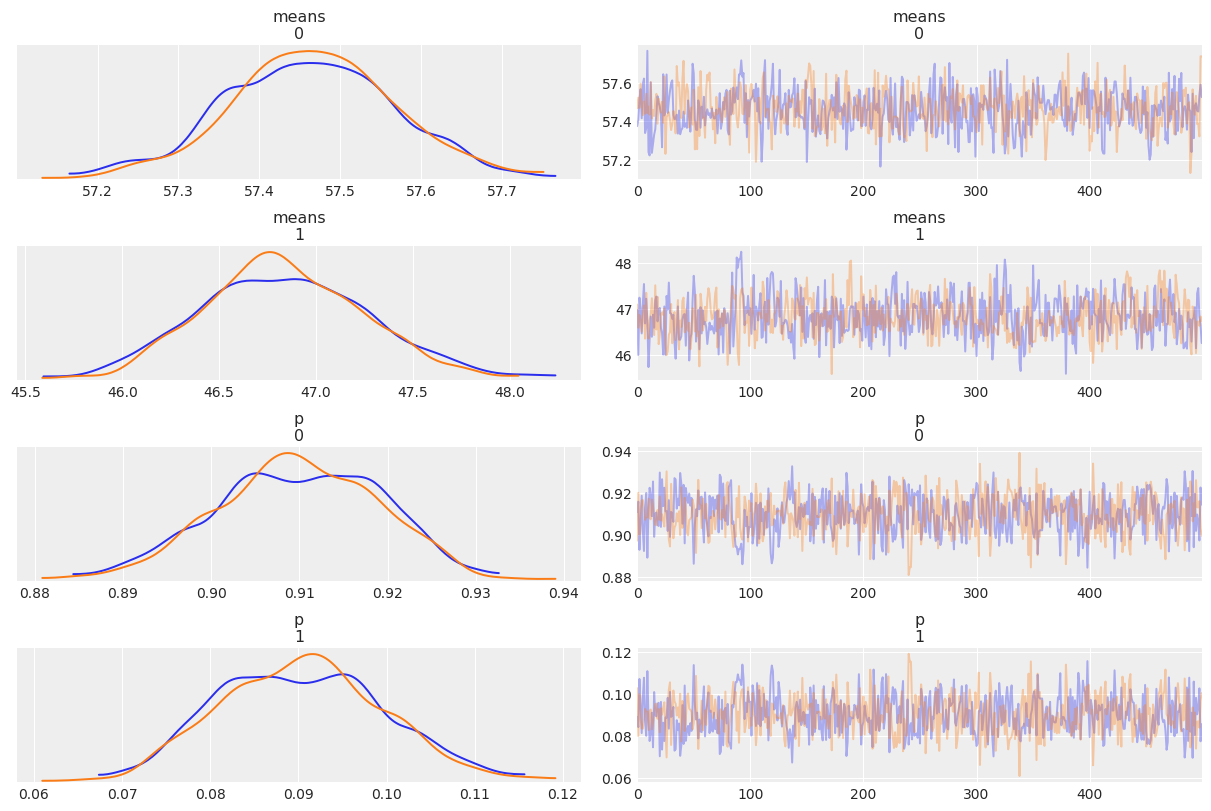

In [7]:
varnames = ['means', 'p']
az.plot_trace(trace_mg, varnames)
plt.savefig('B11197_06_06.png')

In [8]:
az.summary(trace_mg, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],57.462,0.103,57.273,57.661,0.004,0.003,781.0,781.0,785.0,671.0,1.0
means[1],46.832,0.430,46.122,47.722,0.018,0.013,556.0,554.0,568.0,460.0,1.0
p[0],0.910,0.009,0.893,0.927,0.000,0.000,647.0,647.0,648.0,667.0,1.0
p[1],0.090,0.009,0.073,0.107,0.000,0.000,647.0,637.0,648.0,667.0,1.0


## Non-identifiability of mixture models
如果仔细检查图6.6，将会发现有趣的事情。 两种均值都将估计为双峰分布，其值大约为（47,57.5），如果您查看用z获得的汇总，则将其均估计为。 总结来说，均值的平均值几乎相等，大约为52。我们可以看到与p值相似的东西。 这是统计中称为参数不可识别性的现象的示例。 发生这种情况是因为如果分量1的平均值为47，分量2的平均值为57.5，反之亦然，则模型相同。 两种情况完全相同。 在混合模型的上下文中，这也称为标签切换问题。 当我们讨论具有高相关性的线性模型和变量时，我们已经在第3章“使用线性回归建模”中找到了参数不可识别性的示例。

如果可能，应该定义模型以消除不可识别性。对于混合模型，至少有两种方法可以做到这一点：(如果为多个模型参数选择获得了相同的似然函数，则无法识别模型中的参数。)

1、强制订购组件； 例如，以严格的顺序排列组件的方式

2、使用信息先验

使用PyMC3，强制执行要订购的组件的一种简单方法是使用（pm.potential（））。 潜在因素是我们添加到似然中的任意因素，而没有在模型中添加变量。 似然和潜在因素之间的主要区别在于，潜在因素不一定取决于数据，而似然则取决于数据。 我们可以使用潜在因素来实施约束。 例如，我们可以这样定义潜在的因素：如果不违反约束，我们给似然加上零。 否则，我们增加一个负无穷因素。 最终结果是，模型认为违反约束的参数（或参数组合）是不可能的，而模型对其余的值不受干扰：

In [16]:
np.array([.9, 1] ) * cs_exp.mean()

array([50.85925845, 56.51028716])

In [9]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',
                               tt.switch(means[1]-means[0] < 0,
                                         -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mgp = pm.sample(1000, random_seed=123,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:08<00:00, 172.22it/s]
The acceptance probability does not match the target. It is 0.8922333021204084, but should be close to 0.8. Try to increase the number of tuning steps.


我们可能会发现有用的另一种约束是确保所有成分的概率都不为空，或者换句话说，混合物中的每种成分至少都附有一个观测值。 您可以使用以下表达式执行此操作：
p_min = pm. Potential(' p_min' , tt. switch(tt. min(p) < min_p, -np. inf, 0) )

Here, you can set min_p to some arbitrary, but reasonable value, such as 0.1 or 0.01

#### instead of a potential we can use an ordered transformation
#### transform=pm.distributions.transforms.ordered

从图6.4中可以看出，α值控制Dirichlet分布的浓度。 如model_mgp中所使用的，使用α = 1获得单纯形上的平坦先验分布。 α值越大意味着先验信息越多。 经验证据表明，α = 4或10的值通常是一个很好的默认选择，因为这些值通常会导致后验分布，每个分量至少分配有一个数据点，同时减少了高估分量数的机会。

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

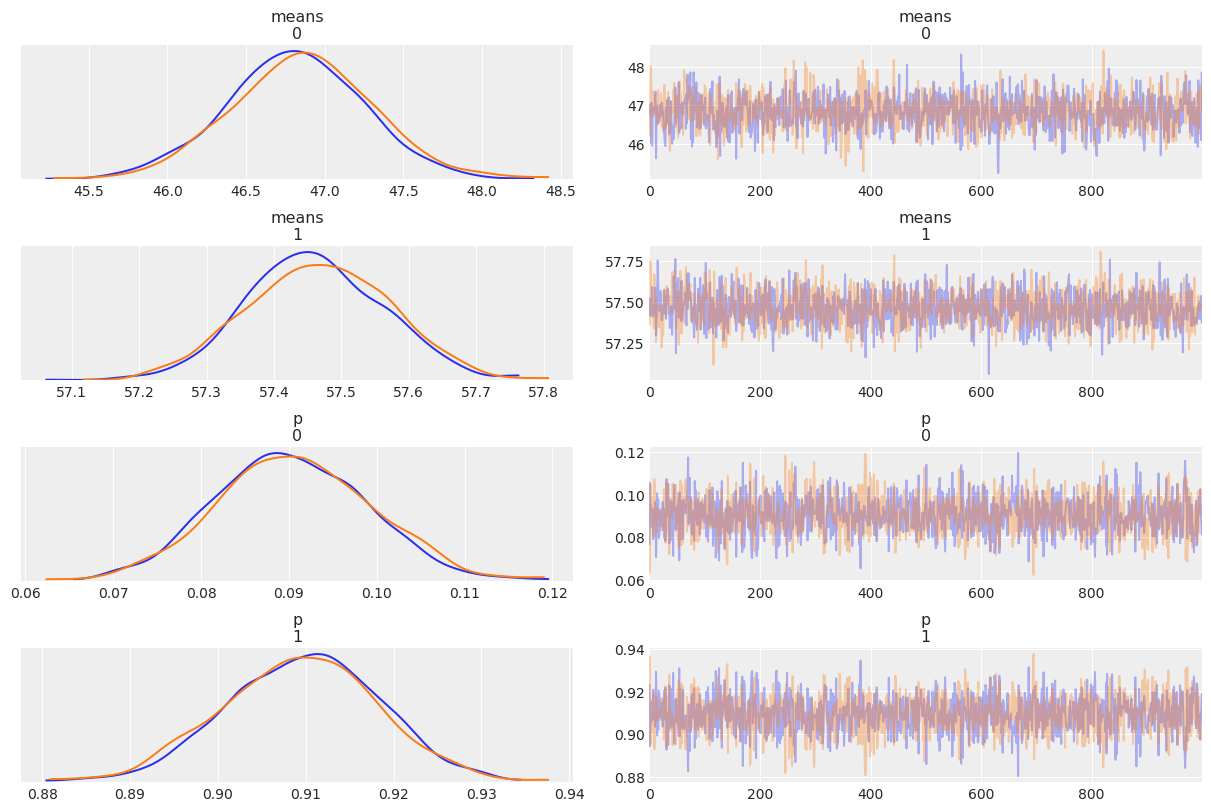

In [17]:
varnames = ['means', 'p']
az.plot_trace(trace_mgp, varnames)
plt.savefig('B11197_06_07.png')

In [18]:
az.summary(trace_mgp)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],46.834,0.438,46.020,47.653,0.012,0.009,1317.0,1317.0,1342.0,1257.0,1.0
means[1],57.463,0.102,57.278,57.657,0.002,0.002,1680.0,1680.0,1677.0,1658.0,1.0
p[0],0.091,0.009,0.075,0.107,0.000,0.000,1560.0,1557.0,1553.0,1354.0,1.0
p[1],0.909,0.009,0.893,0.925,0.000,0.000,1560.0,1560.0,1553.0,1384.0,1.0
sd,3.650,0.073,3.520,3.789,0.002,0.001,1881.0,1878.0,1881.0,1604.0,1.0


## How to choose K
有限混合模型的主要问题之一是如何确定零件数量。 经验法则是从数量相对较少的组件开始，然后增加组件数量以改善模型拟合评估。 像往常一样，使用后验预测检查，WAIC或LOO之类的措施并根据建模人员的专业知识来评估模型拟合。

让我们比较一下k = {3,4,5,6}的模型。 为此，我们将对模型进行四次拟合，并且将保存跟踪和模型对象以供以后使用：

In [3]:
cluster=2
np.linspace(cs_exp.min(), cs_exp.max(), cluster)

array([42.8, 69.1])

In [4]:
clusters = [3, 4, 5, 6]

models = []
traces = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10, shape=cluster,
                          transform=pm.distributions.transforms.ordered) 
#Applies inverse of transformation to input variable z. When transform is used on some distribution p, which has observed values z, it is used to transform the values of z correctly to the support of p.
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123,cores=1,target_accept=0.9)
        traces.append(trace)
        models.append(model)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 3000/3000 [00:58<00:00, 51.45it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 3000/3000 [00:58<00:00, 51.46it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|██████████████████████

In [5]:
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
x_ = np.array([x] * 3).T
x_[0:3]

array([[42.8       , 42.8       , 42.8       ],
       [42.9321608 , 42.9321608 , 42.9321608 ],
       [43.06432161, 43.06432161, 43.06432161]])

In [6]:
p_y = traces[0]['p'].mean(0)
means_y = traces[0]['means'].mean(0)
sd = traces[0]['sd'].mean()
dist = stats.norm(means_y, sd)
p_y

array([0.08421492, 0.64798594, 0.26779976], dtype=float32)

In [7]:
(dist.pdf(x_) * p_y)[0:3]

array([[5.96979807e-03, 3.67252248e-07, 4.29718454e-13],
       [6.34793895e-03, 4.72393711e-07, 6.15009856e-13],
       [6.73277171e-03, 6.06082578e-07, 8.77946789e-13]])

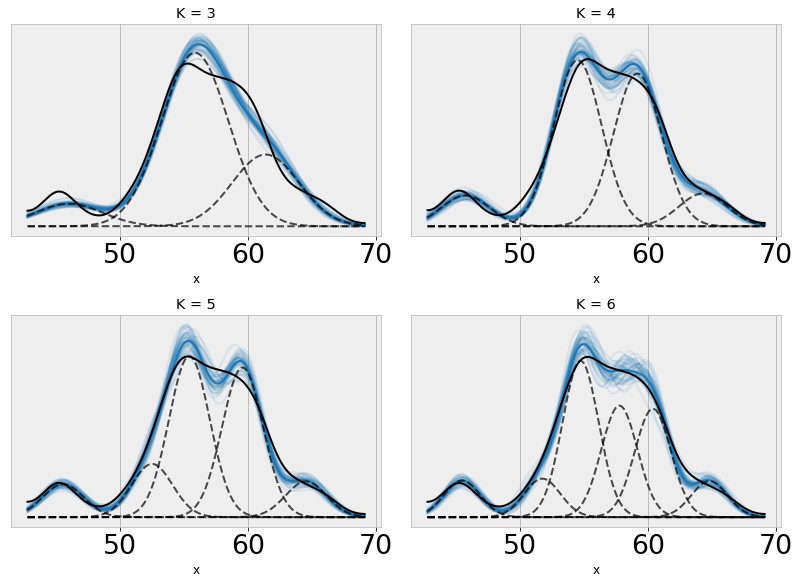

In [8]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = np.ravel(ax)   #降维
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)
 
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig('B11197_06_08.png')

图6.8显示了数据的KDE图，黑色实线以及均值拟合较宽（蓝色）线和后半透明（蓝色）线的样本。 同样，平均高斯分量也用黑色虚线表示。 在图6.8中，似乎k = 3太低，而4、5或6可能是更好的选择。

请注意，高斯混合模型显示了两个中心峰/凸点（或多或少在55-60附近），而KDE预测的峰不那么明显（更平坦）。 请注意，这不一定是高斯混合模型的不利拟合，因为通常对KDE进行了调整以提供更平滑的密度。 可以使用直方图代替KDE，但直方图也是近似密度的方法。 正如我们在第5章“模型比较”中已经讨论的那样，您可以尝试计算感兴趣的测试量的预测后验图并计算贝叶斯p值。 图6.9显示了这种计算和可视化的示例：

In [53]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i])
          for i in range(4)]

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.10it/s]
C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 13.95it/s]


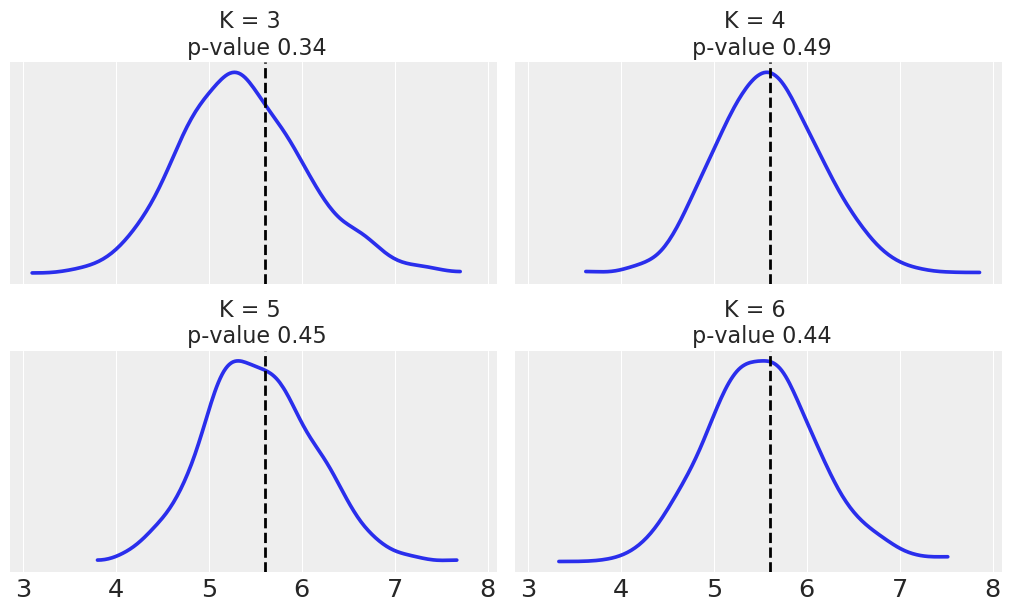

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])
plt.savefig('B11197_06_09.png')

从图6.9中可以看出，k=6该数字是一个很好的选择，贝叶斯p值非常接近0.5。 正如我们在以下DataFrame和图6.10中所看到的，k=6WAIC也被认为是更好的模型（在评估模型中）：

In [55]:
comp = az.compare(dict(zip(clusters, traces)), method='BB-pseudo-BMA')
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,10248.9,12.212,0,0.94655,64.3739,0,False,deviance
5,1,10258.8,10.0356,9.90895,0.0492003,63.2788,5.00235,False,deviance
4,2,10279.3,7.67466,30.4233,0.00424976,62.1909,10.0269,False,deviance
3,3,10357,5.98914,108.166,6.03869e-13,62.2998,18.6548,False,deviance


通常，不读取图要比读取表格更容易，因此让我们作图以发现根据WAIC的不同模型的情况。 从图6.10中可以看出，虽然具有六个组成部分的模型的WAIC低于其余模型，但在考虑估计的标准误差（se）时存在相当大的重叠，特别是对于具有五个组成部分的模型：

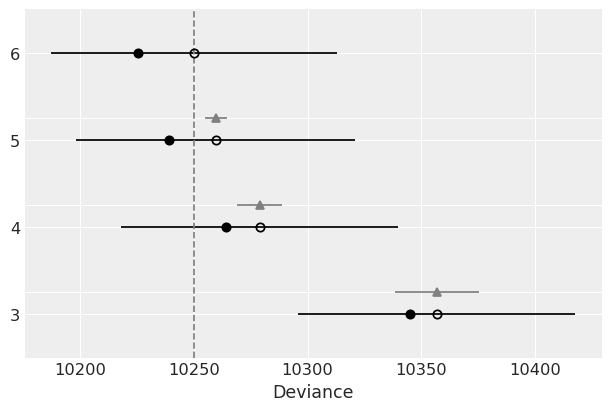

In [18]:
az.plot_compare(comp)
plt.savefig('B11197_06_10.png')

## Mixture models and clustering
聚类是无监督统计或机器学习任务系列的一部分，类似于分类，但是由于我们不知道正确的标签而更加困难！

聚类或聚类分析是对对象进行分组的数据分析任务，以使给定组中的对象比其他组中的对象彼此更靠近。这些组称为簇，可以用许多不同的方法来计算紧密度。例如，通过使用诸如欧几里得距离之类的指标。如果取而代之，我们采取概率路线，那么混合模型将成为解决聚类任务的自然候选者。

使用概率模型执行聚类通常称为基于模型的聚类。使用概率模型使我们能够计算属于每个聚类的每个数据点的概率。与硬群集相反，这称为软群集，在硬群集中，每个数据点都属于概率为0或1的群集。我们可以通过引入一些规则或边界将软群集转换为硬群集，实际上您可能还记得，这正是我们将逻辑回归转换为分类方法的工作，在该方法中，我们使用默认值0.5作为边界。对于聚类，合理的选择是将数据点分配给具有最高概率的聚类。

总而言之，当人们谈论聚类时，他们通常是在对对象进行分组，而当人们谈论混合模型时，他们则在谈论使用简单分布的混合来建模更复杂的分布，以识别子组或只是具有更多的分布。灵活的模型来描述数据。

## Non-finite mixture model
对于某些问题，例如尝试对手写数字进行聚类，很容易证明我们期望在数据中找到的组数是合理的。 对于其他问题，我们可以有个很好的猜测； 例如，我们可能知道我们的鸢尾花样品是从只有三种鸢尾花生长的地区采集的，因此使用三个成分是一个合理的起点。 当我们不确定组件的数量时，可以使用模型选择来帮助我们选择组的数量。 但是，对于其他问题，选择先验数量可能会有所不足，因此，我们有兴趣从数据中估算该数量。 针对此类问题的贝叶斯解决方案与Dirichlet过程有关。
## Dirichlet process
到目前为止，我们所看到的所有模型都是参数模型。 这些模型具有固定数量的参数，我们有兴趣估算这些参数，例如固定数量的集群。 我们也可以有非参数模型，这些模型的更好的名字应该是非固定参数模型，但是已经有人为我们决定了名称。 非参数模型是具有理论上无限数量参数的模型。 在实践中，我们以某种方式让数据将理论上无限的参数减少到一定数量，换言之，数据决定了参数的实际数量，因此非参数模型非常灵活。 在本书中，我们将看到这样的模型的两个示例：高斯过程（这是下一章的主题）和狄利克雷过程，我们将在下一段中开始讨论。

由于Dirichlet分布是β分布的n维概括，因此Dirichlet过程（DP）是Dirichlet分布的无穷维概括。 Dirichlet分布是概率空间上的概率分布，而DP是分布空间上的概率分布，这意味着来自DP的单次抽签实际上是一个分布。 对于有限混合模型，我们使用Dirichlet分布为固定数目的群集或组分配先验。 DP是一种将先验分布分配给非固定数量的群集的方法，甚至我们可以将DP视为一种从先验分布的分布中采样的方法。

在转向实际的非参数混合模型之前，让我们花一点时间来讨论DP的一些细节。 DP的正式定义有些晦涩难懂，除非您对概率论非常了解，所以让我描述一些DP的属性，这些属性与理解其在混合模型建模中的作用有关：

DP是一种分布，其实现是概率分布，而不是像高斯分布那样说实数。

DP由基本分布和称为浓度参数的正实数\ alpha指定（这类似于Dirichlet分布中的浓度参数）。

H是DP的期望值，这意味着DP将在基本分布周围生成分布，这在某种程度上等效于高斯分布的平均值。

随着\ alpha的增加，实现变得越来越集中。

实际上，DP总是生成离散分布。

在极限趋近无穷中，DP的实现将等于基本分布，因此，如果基本分布是连续的，则DP将生成连续的分布。 因此，数学家说从DP产生的分布几乎肯定是离散的。 在实践中，由于数量有限，我们将始终使用离散分布。

为了使这些属性更加具体，让我们再次看一下图6.3中的分类分布。 我们可以通过指示x轴上的位置和y轴上的高度来完全指定这种分布。 对于分类分布，将x轴上的位置限制为整数，并且高度的总和必须为1。保留最后一个限制，但放宽前一个限制。 为了生成x轴上的位置，我们将从基本分布中采样。 原则上可以是我们想要的任何分布，因此，如果选择高斯，则位置原则上可以是实线中的任何值，相反，如果选择beta，则位置将被限制为间隔[0，1]，如果 我们选择Poisson作为基本分布，位置将限制为非负整数{0，1，2，......}。

到目前为止，我们如何选择y轴上的值？ 我们遵循被称为“折断”过程的Gedanken实验。 假设我们有一根长度为1的木棒，然后将其分成两部分（不一定相等）。 我们将一部分放在一边，然后将另一部分分成两部分，然后我们将永远做到这一点。 在实践中，由于我们不能真正无限地重复该过程，因此我们将其截断为某个预定义的值，但是总的想法仍然成立。 为了控制不停的过程，我们使用一个参数。 随着我们增加α的值，我们将越来越少地折断棒。 因此，在这种情况下，我们不会刹车，也不会在我们将其分成无数碎片时制动。 图6.11显示了来自DP的四个绘图，其中有四个不同的值。 我将在稍后解释生成该图的代码，首先让我们先了解这些样本告诉我们有关DP的内容：

从图6.10可以看出，DP是离散分布。 当α增加时，我们获得了更大的散布分布和较小的棒块，请注意y轴的比例变化，并记住总长度固定为1。基本分布控制位置，因为位置是从 从图6.10中可以看出，随着α的增加，DP分布的形状越来越类似于基本分布H，由此我们可以希望看到α趋近无穷在其中我们应该准确地获得基本分布。我们可以将DP视为随机分布f上的先验概率，其中基本分布是我们期望f的期望值，而浓度参数表示我们对先验猜测的置信度。

图6.1显示，如果在每个数据点的顶部放置一个高斯，然后对所有高斯求和，则可以近似得出数据的分布。 我们可以使用DP来做类似的事情，但是我们可以在DP实现中将高斯分布在每个子棒的位置上，而不是在每个数据点的顶部放置高斯，然后根据子棒的长度缩放或加权高斯。 。 此过程为无限高斯混合模型提供了一般方法。 或者，我们可以用高斯分布代替任何其他分布，并且我们将获得通用无限混合模型的通用配方。 图6.12显示了这种模型的示例，我们使用了拉普拉斯分布的混合。 我任意选择一个Laplace分布只是为了增强您不受任何限制地进行高斯混合模型的想法：

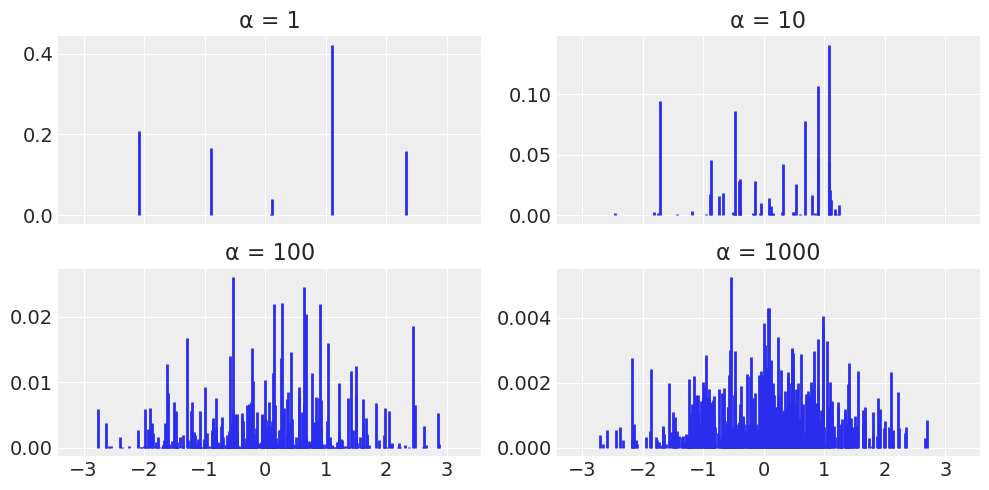

In [56]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : scipy distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))  #βs[:-1]不包含最后一个元素
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))

plt.tight_layout()
plt.savefig('B11197_06_11.png')

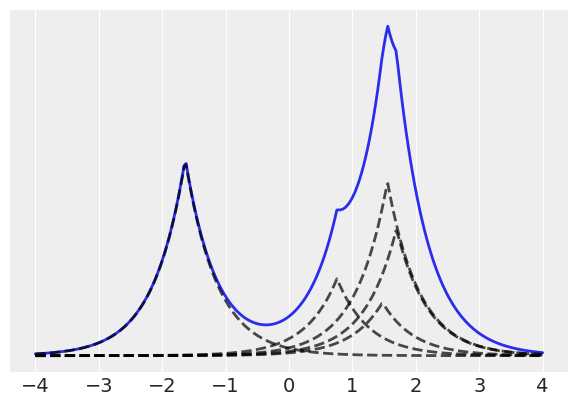

In [70]:
α = 10
H = stats.norm
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.savefig('B11197_06_12.png')

我希望此时您对DP有一个很好的直觉，唯一仍然缺少的细节是了解功能stick_break_truncated。 在数学上，DP的折断过程视图可以通过以下方式表示：

![title](6_1.png)

In [9]:
#N = cs_exp. shape[0]
K = 20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [10]:
cs_exp1=(cs_exp-cs_exp.mean())/cs_exp.std()

#### 与原有的例子相比，有两点变化，一个是要init="adapt_diag"
#### 另外一个是要对数据进行归一化处理。

In [11]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp1.min(), cs_exp1.max(), K),
                      sd=10, shape=K)
    
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp1.values)
    trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept':0.9},cores=1,init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, β, α]
Sampling chain 1, 192 divergences: 100%|███████████████████████████████████████████| 3000/3000 [11:25<00:00,  4.38it/s]
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.
There were 423 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


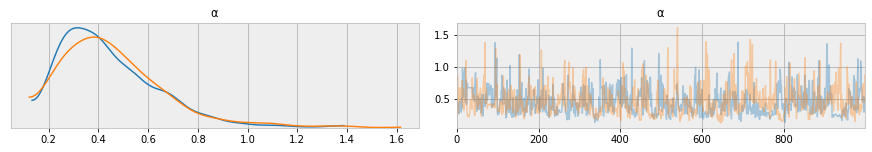

In [12]:
az.plot_trace(trace, var_names=['α'], divergences=False);
plt.savefig('B11197_06_13.png')

In [13]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],0.179,0.080,0.058,0.294,0.053,0.044,2.0,2.0,3.0,84.0,1.83
means[1],-2.364,0.023,-2.405,-2.320,0.001,0.000,1460.0,1455.0,1443.0,936.0,1.00
means[2],0.709,1.158,-0.526,1.975,0.815,0.689,2.0,2.0,3.0,98.0,1.83
means[3],-1.440,9.260,-19.070,15.653,0.215,0.250,1862.0,686.0,1851.0,1163.0,1.00
means[4],-1.438,9.547,-18.691,16.886,0.258,0.265,1370.0,651.0,1330.0,614.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
sd[15],8.085,5.966,0.006,18.944,0.129,0.091,2147.0,2147.0,1399.0,867.0,1.00
sd[16],7.991,5.564,0.037,17.925,0.122,0.086,2077.0,2077.0,1453.0,815.0,1.00
sd[17],8.063,5.851,0.002,18.128,0.139,0.098,1767.0,1767.0,1003.0,330.0,1.00
sd[18],7.678,5.954,0.003,18.432,0.148,0.105,1610.0,1610.0,994.0,415.0,1.00


从图6.13中我们可以看到a的值相当低，表明描述数据需要一些组件。

因为我们要通过截断的棍棒破坏程序来逼近无限大的DP，所以检查截断值（在此示例中为k = 20）没有引入任何偏差非常重要。 一种简单的方法是绘制每个组件的平均重量，为了安全起见，我们应该有几个重量可以忽略不计的组件，否则我们必须增加截断值。 图6.14是这类绘图的一个例子。 我们可以看到只有少数几个重要组成部分很重要，因此我们可以确信，所选的的上限值对于该模型和数据而言足够大：

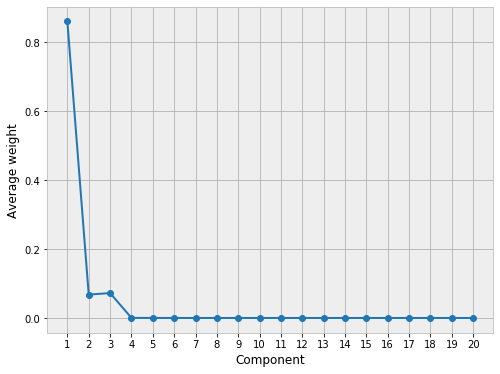

In [14]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.savefig('B11197_06_14.png')

In [15]:
x=np.linspace(1, 2, 200)
print(np.atleast_3d(x).shape)
x[ np.newaxis,:].shape

(1, 200, 1)


(1, 200)

In [15]:
x_plot = np.linspace(cs_exp1.min()-1, cs_exp1.max()+1, 200)

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace['means'][:, np.newaxis, :],
                                   trace['sd'][:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

图6.15显示了使用DP模型（黑色）线估计的平均密度以及后（灰色）线的样本，以反映估计中的不确定性。 与图6.2和图6.8中的KDE相比，该模型还显示出较低的平滑密度：

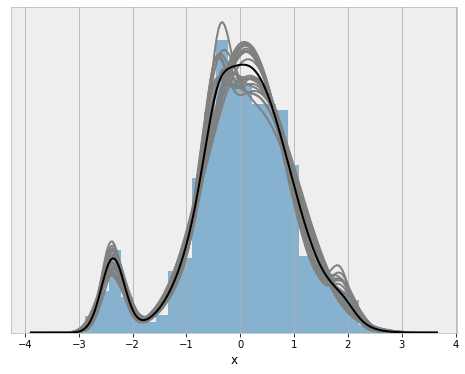

In [16]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp1.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('B11197_06_15.png')

## Continuous mixtures
本章重点讨论离散混合模型，但我们也可以使用连续混合模型。确实，我们已经知道了其中一些，例如第4章“广义线性模型”中的零膨胀分布，其中混合了泊松分布和零生成过程。另一个示例是同一章中的健壮的逻辑回归模型，该模型由两个部分组成：一方面是逻辑模型，另一方面是随机猜测。请注意，该参数不是打开/关闭开关，而是更像一个混合旋钮，用于控制我们在混合中具有多少随机猜测和逻辑回归。仅对于极值，我们才具有纯随机猜测或纯逻辑回归。

层次模型也可以解释为连续混合模型，其中每个组中的参数都来自上层的连续分布。为了更具体，请考虑对多个组执行线性回归。我们可以假设每个组都有自己的斜率，或者所有组共享相同的斜率。替代地，代替将我们的问题归结为两个极端和离散选项，层次模型允许我们有效地对这些极端选项的连续混合进行建模，因此，极端选项只是该较大层次模型的特殊情况。

## Beta-binomial and negative binomial
β-二项式是一种离散分布，通常用于描述n个伯努利试验的成功次数y，其中每个试验的成功概率p未知并且假定服从参数a和β的beta分布：

![title](6_2.png)

也就是说，为了找到观察结果y的可能性，我们对p的所有可能（和连续）值取平均值。 因此，可以将β-二项式视为连续混合模型。 如果您对β二项式模型感到熟悉，那是因为您一直在关注本书的前两章！ 尽管我们明确使用beta和二项分布，而不是使用已经混合的beta-二项分布，但这是我们用于硬币翻转问题的模型。

以类似的方式，我们具有负二项式分布，可以理解为伽马-泊松混合。对于此模型，速率参数为伽玛分布时，我们混合了泊松分布。此分布通常用于避免处理计数数据时遇到的常见问题。这个问题被称为过度分散。假设您使用Poisson分布对计数数据进行建模，然后您意识到数据的方差超过了模型的方差；使用泊松分布的问题在于均值和方差是关联的（实际上，它们是由相同的参数描述的）。因此，解决此问题的一种方法是将数据建模为泊松分布的（连续）混合，其速率来自伽玛分布，这为我们提供了使用负二项式分布的原理。由于我们现在正在考虑混合分布，因此我们的模型具有更大的灵活性，可以更好地适应观察到的数据均值和方差。 β二项式和负二项式都可以用作线性模型的一部分，并且都具有零膨胀版本。而且，两者都在PyMC3上以即用型分布的形式实现。

## The Student's t-distribution
我们将学生的t分布介绍为高斯分布的可靠替代。 事实证明，学生的t分布也可以视为连续混合。 在这种情况下，我们有：

![title](6_3.png)

请注意，这与负二项式的先前表达式相似，除了这里我们有一个带有参数\ mu和\ delta的正态分布，以及一个带有参数v的inv卡方分布，我们从中采样\ delta的值是 参数，称为自由度，或我们更喜欢称其为正常性参数。 参数v以及β二项式的p等于有限混合模型的z潜在变量。 对于某些有限混合模型，也可以在进行推断之前边缘化相对于潜在变量的分布，这可能导致更易于采样模型，正如我们在边缘化混合模型示例中已经看到的那样。 

## summary 
许多问题可以描述为由不同亚群组成的总体种群。 当我们知道每个观测值属于哪个子群体时，我们可以将每个子群体专门建模为一个单独的组。 但是，很多时候我们无法直接访问此信息，因此使用混合模型对数据进行建模可能更合适。 我们可以使用混合模型来尝试捕获数据中的真实子种群，也可以使用一般的统计技巧通过组合更简单的分布来对复杂的分布进行建模。 我们甚至可以尝试在中间做一些事情。

在本章中，我们将混合模型分为三类-有限混合模型，无限混合模型和连续混合模型。有限混合模型是两个或多个分布的有限加权混合，每个分布或分量代表数据的子组。原则上，这些组件实际上可以是我们认为有用的任何东西，从简单的分布（例如高斯或泊松）到更复杂的对象（例如层次模型或神经网络）。从概念上讲，要解决混合模型，我们要做的就是将每个数据点正确分配给组件之一，我们可以通过引入潜在变量来实现。我们对进行分类分配，这是最通用的离散分布，而Dirichlet优先于Dirichlet，这是β分布的n维概括。对离散变量进行采样可能会出现问题，因此可能会使其边缘化。 PyMC3包括正态混合物分布和对我们执行此边缘化作用的混合物分布，使使用PyMC3建立混合物模型更加容易。使用混合模型时，一个常见问题是该模型可能导致标签交换问题，这是一种不可识别的形式。消除不可识别性的一种方法是强制订购组件，使用PyMC3，我们可以使用pm来实现。pm. potential() or an ordered transformation（请参阅随附的Jupyter笔记本）。

有限混合模型的挑战之一是如何决定零件的数量。 一种解决方案是围绕一组估计数量的组件对一组模型进行模型比较，在可能的情况下，应该通过我们对当前问题的了解来指导估计。 另一个选择是尝试根据数据自动估计组件的数量。 因此，我们引入了DP的概念，我们用它来考虑无限混合模型。 DP是Dirichlet分布的无穷大版本，我们可以使用它来建立非参数混合模型。

在本章结束时，我们简要讨论了多少种模型（例如，β二项式（用于硬币翻转问题的模型），负二项式，学生的t分布甚至分层模型）可以解释为连续混合模型。

In [27]:
## Exercises
#clusters = 3
#n_cluster = [200, 150, 170]
#n_total = sum(n_cluster)
#means = [5, 0, -3]
#std_devs = [2, 2, 2]
#mix = np.random.normal(np.repeat(means, n_cluster),
#np.repeat(std_devs, n_cluster))
#az.plot_kde(np.array(mix));

## Exercises
1. Generate synthetic from a mixture of three Gaussians. Check the
accompanying Jupyter Notebook for this chapter for an example on
how to do this. Fit a finite Gaussian mixture model with 2, 3, or 4
components.

In [21]:
stats.norm.rvs(loc=[10,20,30], scale=1, size=(100,3)).ravel().shape

(300,)

In [22]:
vals = stats.norm.rvs(loc=[10,20,30], scale=1, size=(100,3)).ravel()
vals[:5]

array([10.02818116, 19.990881  , 31.08589557, 10.47469823, 19.97497304])

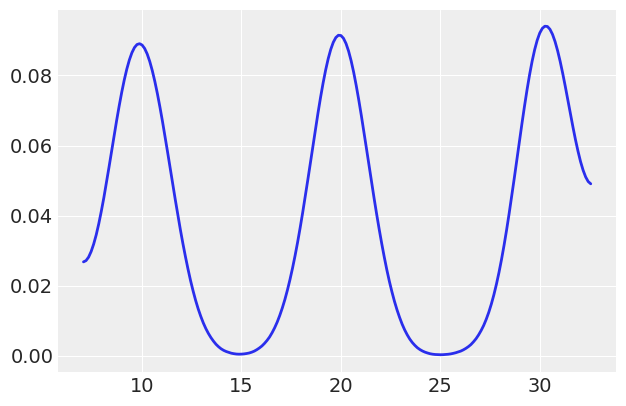

In [23]:
az.plot_kde(vals)

In [24]:
clusters = [2,3, 4]
traces=[]
models=[]
tracep={}
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(vals.min(), vals.max(), cluster),
                          sd=10, shape=cluster,
                          transform=pm.distributions.transforms.ordered) 
#Applies inverse of transformation to input variable z. When transform is used on some distribution p, which has observed values z, it is used to transform the values of z correctly to the support of p.
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=vals)
        trace = pm.sample(1000, tune=2000, random_seed=123,cores=1,target_accept=0.9)
        traces.append(trace)
        models.append(model)
        tracep[f"Cluster Size {cluster}"] = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 3000/3000 [00:14<00:00, 206.66it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 3000/3000 [00:22<00:00, 135.16it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 14 divergences: 100%|████████████████████████████████████████████| 3000/3000 [02:09<00:00, 23.13it/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0

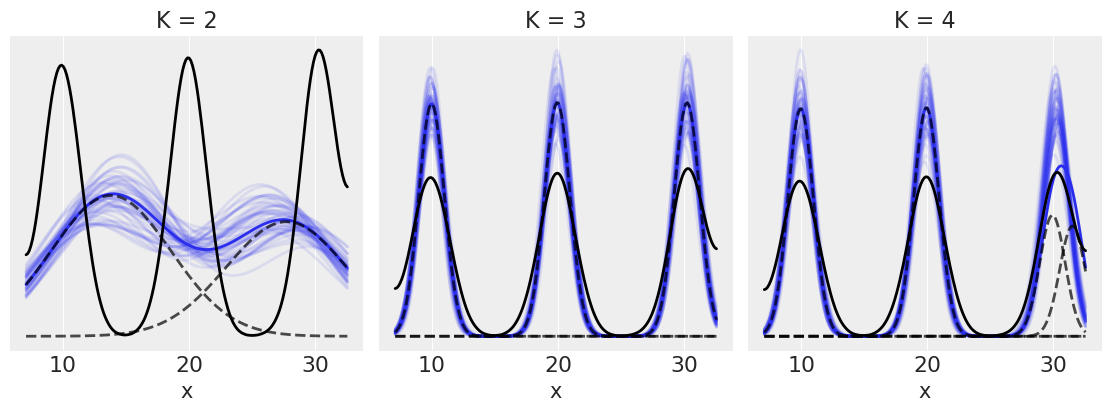

In [25]:
_, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True)
 
ax = np.ravel(ax)   #降维
x = np.linspace(vals.min(), vals.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)
 
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
         
    az.plot_kde(vals, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

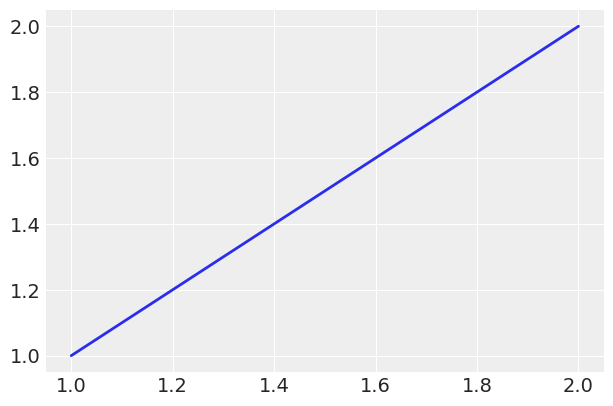

In [20]:
x=np.linspace(1, 2, 200)
y=np.linspace(1, 2, 200)
plt.plot(x, y, 'C0', lw=2)

Use WAIC and LOO to compare the results from exercise 1.

In [47]:
comparison = az.compare(tracep)
comparison

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Dirichlet process,0,259.053,7.876,0,1,4.3726,0,True,deviance
Cluster Size 3,1,1526.68,5.91425,1267.63,1.14879e-275,24.309,2.04563,False,deviance
Cluster Size 4,2,1527.91,6.12438,1268.86,1.16908e-275,24.2694,2.54636,False,deviance
Cluster Size 2,3,2075.22,2.84084,1816.17,0,24.5583,24.6487,False,deviance


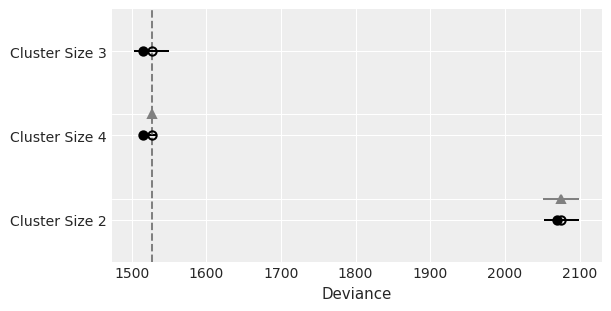

In [27]:
az.plot_compare(comparison)

In [28]:
az.loo(tracep["Cluster Size 2"])

Computed from 2000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo  2075.22     4.50
p_loo      2.84        -

In [29]:
az.loo(tracep["Cluster Size 3"])

Computed from 2000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo  1526.69    24.26
p_loo      5.92        -

In [30]:
az.loo(tracep["Cluster Size 4"])

Computed from 2000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo  1527.92    24.24
p_loo      6.13        -

### 利用无限混合的方法，效果还是杠杠的，语句在下面

In [38]:
az.loo(tracedp)

Computed from 20000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo   259.08    24.48
p_loo      7.89        -

In [45]:
tracep["Dirichlet process"] = az.from_pymc3(trace=tracedp)

In [46]:
tracep

{'Cluster Size 2': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 'Cluster Size 3': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 'Cluster Size 4': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 'Dirichlet process': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data}

Read and run the following examples about mixture models from thePyMC3 documentation ( https: //pymc-devs. github. io/pymc3/examples ):
#### Marginalized Gaussian Mixture Model ( https: //docs. pymc. io/notebooks/marginalized_gaussian_mixture_model. html )
#### Dependent density regression ( https: //docs. pymc. io/notebooks/dependent_density_regression. html )
#### Gaussian Mixture Model with ADVI ( https: //docs. pymc. io/notebooks/gaussian-mixture-model-advi. html) (you will find more information about ADVI in Chapter 8 , Inference Engines)

### Marginalized Gaussian Mixture Model 边际高斯混合模型

In [2]:
SEED = 383561
np.random.seed(SEED) 
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

In [3]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

C:\Users\zhaolei\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


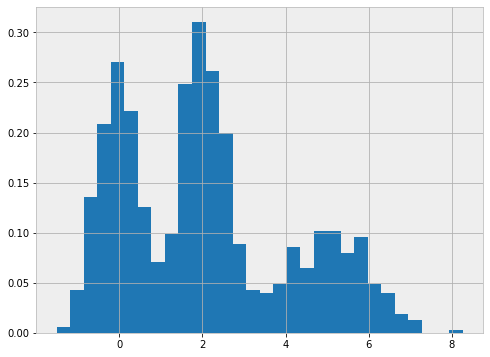

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True, lw=0);

In [55]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=3)
    tau = pm.Gamma('tau', 1., 1., shape=3)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)
    
    trace = pm.sample(5000, n_init=10000, tune=1000, random_seed=SEED,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, mu, w]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 6000/6000 [00:52<00:00, 114.24it/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
with pm.Model() as model1:
    p = pm.Dirichlet('p', a=np.ones(W.size))
    means = pm.Normal('means',
                      mu=np.linspace(x.min(), x.max(), W.size),
                      sd=10, shape=W.size,
                      transform=pm.distributions.transforms.ordered) 
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=x)
    trace1 = pm.sample(5000, n_init=10000, tune=1000, random_seed=SEED,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 6000/6000 [00:38<00:00, 154.82it/s]


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

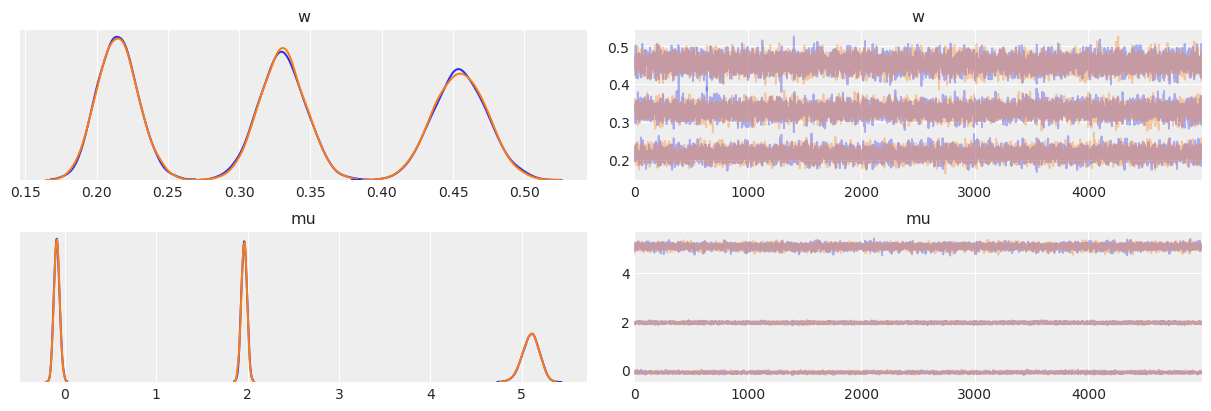

In [154]:
pm.traceplot(trace, var_names=['w', 'mu']);

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

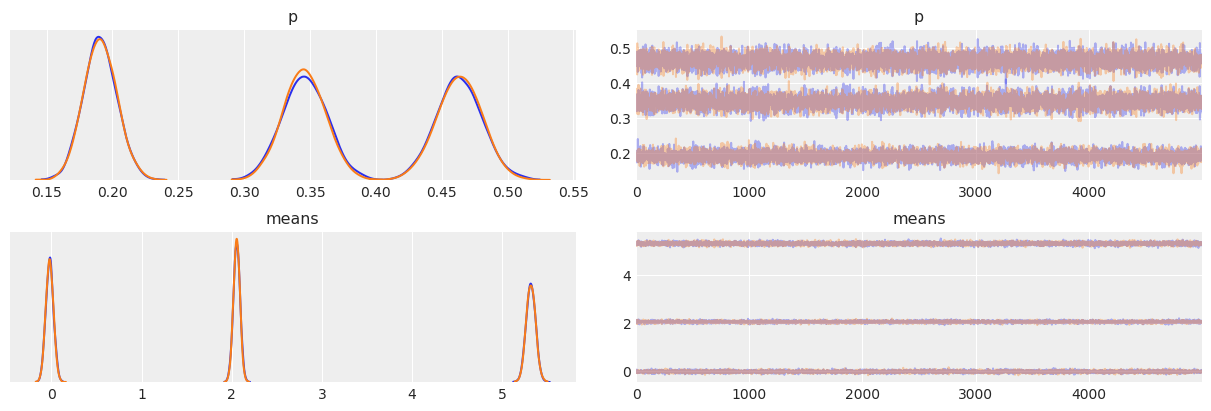

In [163]:
pm.traceplot(trace1, var_names=['p', 'means']);

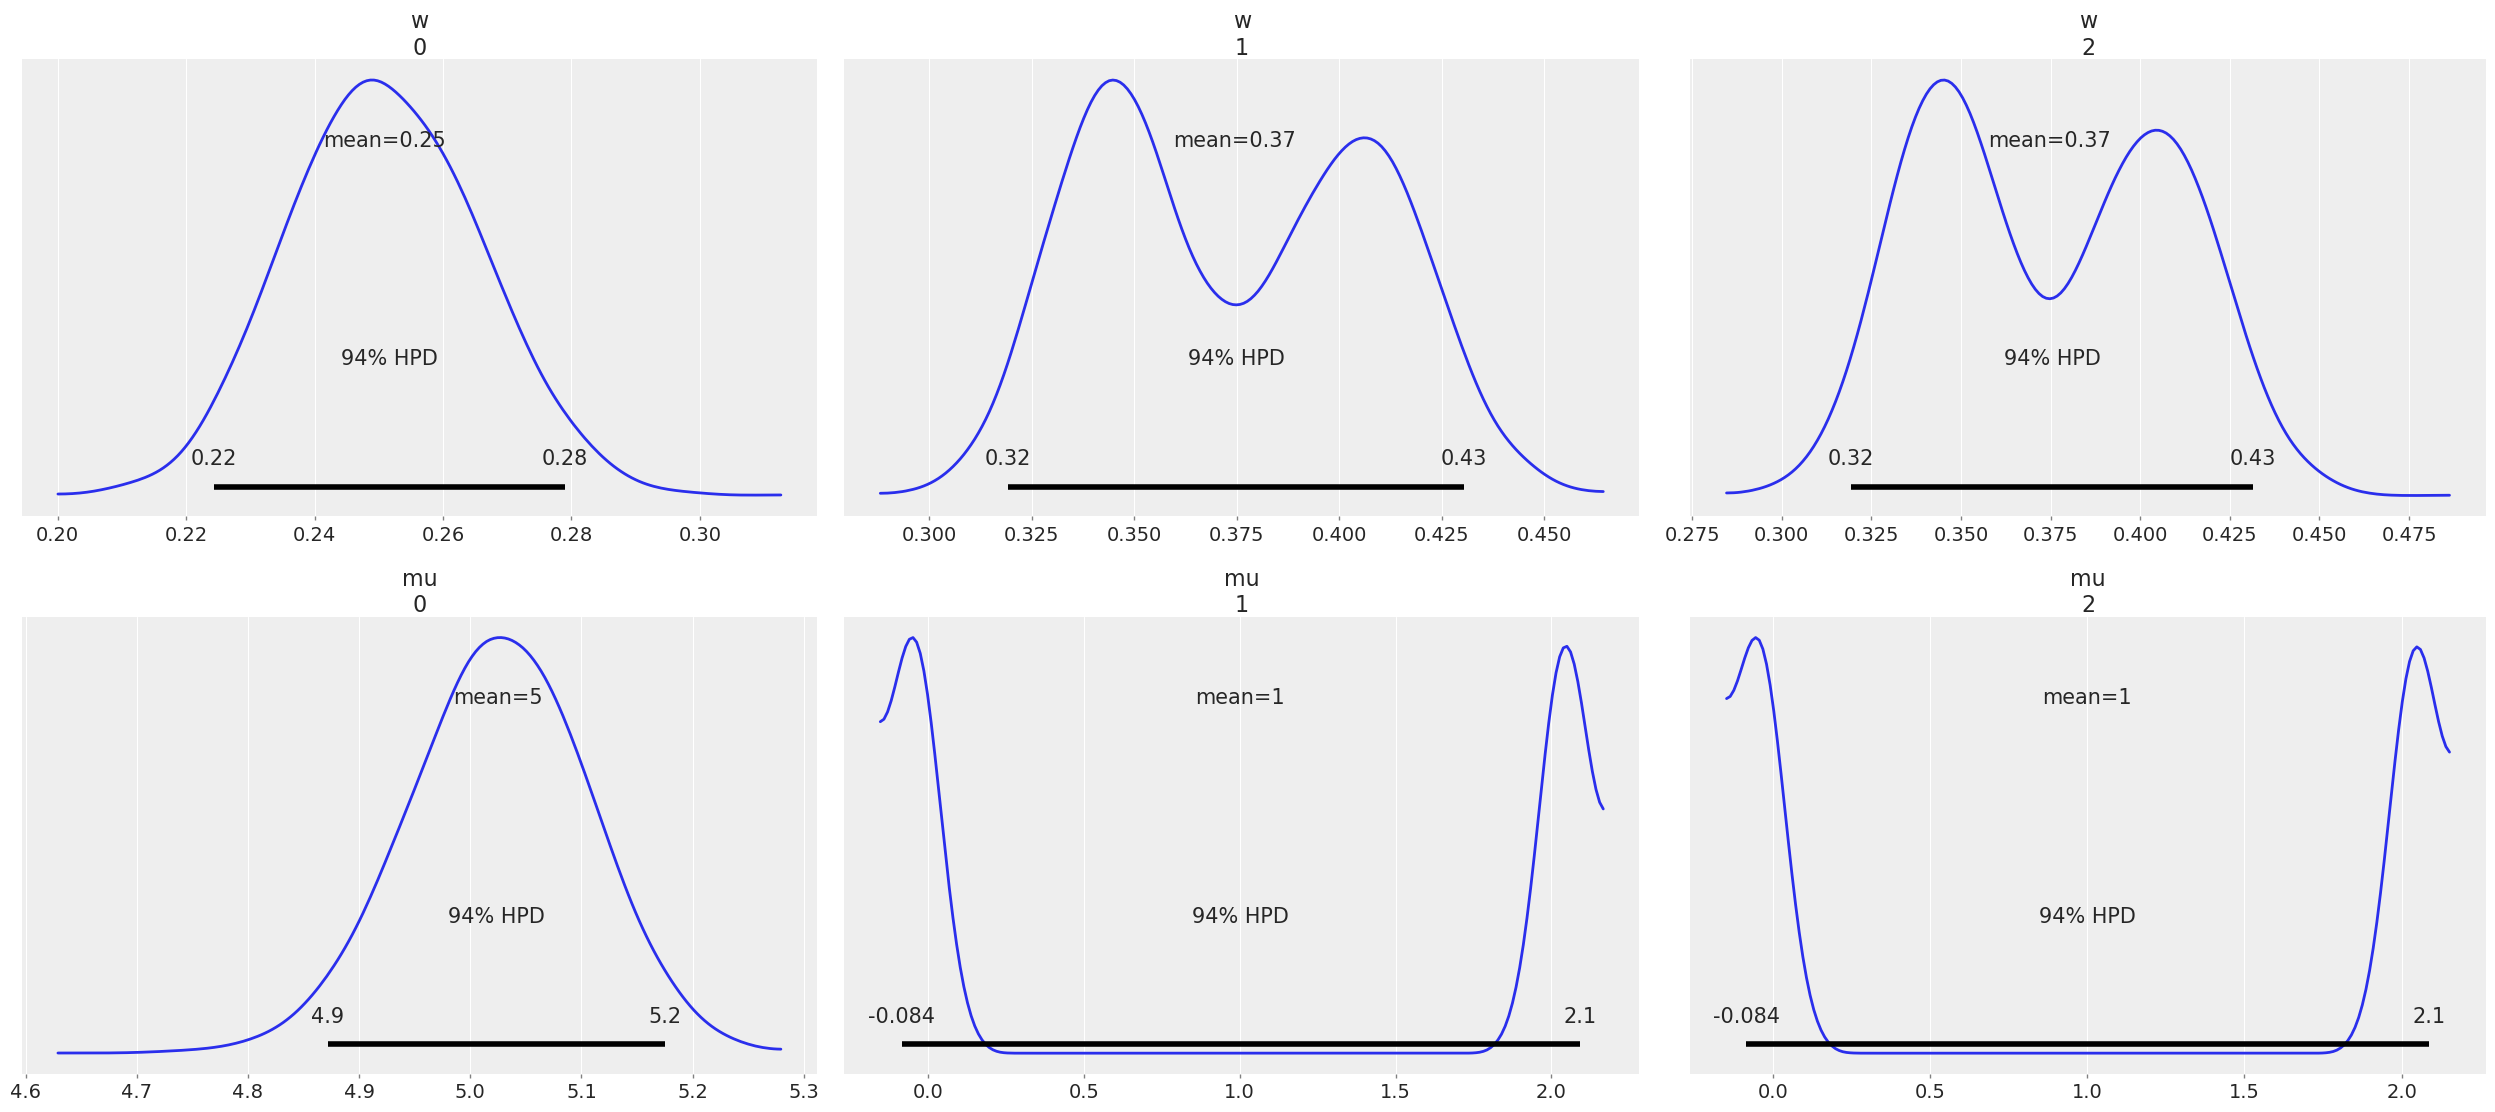

In [59]:
pm.plot_posterior(trace, var_names=['w', 'mu']);

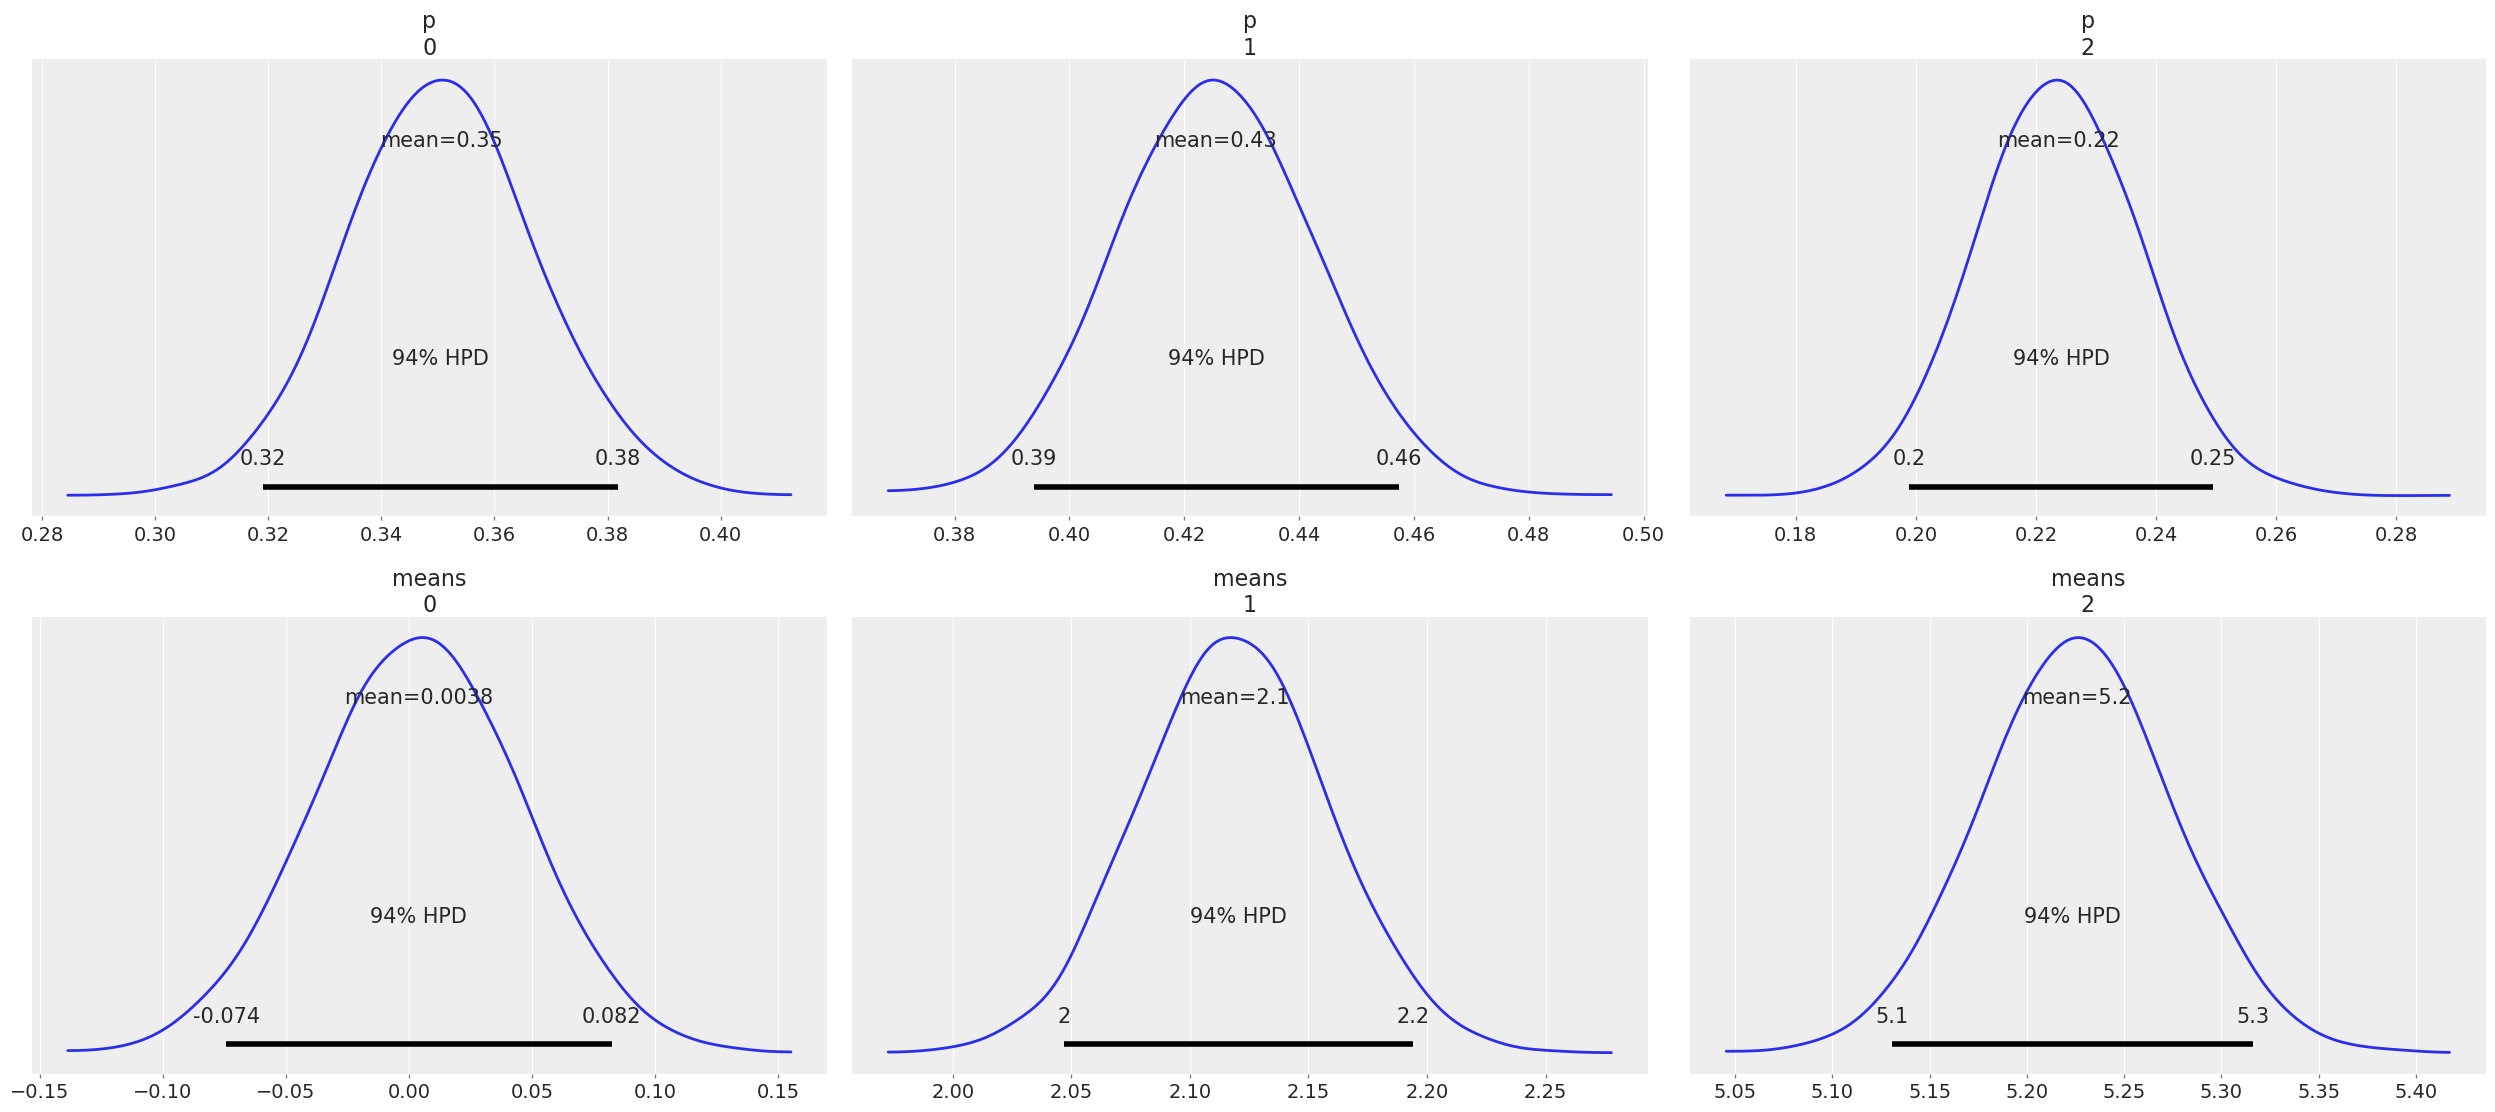

In [60]:
pm.plot_posterior(trace1, var_names=['p', 'means']);

In [61]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000, random_seed=SEED)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:53<00:00, 17.03it/s]


In [6]:
with model1:
    ppc_trace1 = pm.sample_posterior_predictive(trace1, 5000, random_seed=SEED)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:24<00:00, 24.45it/s]


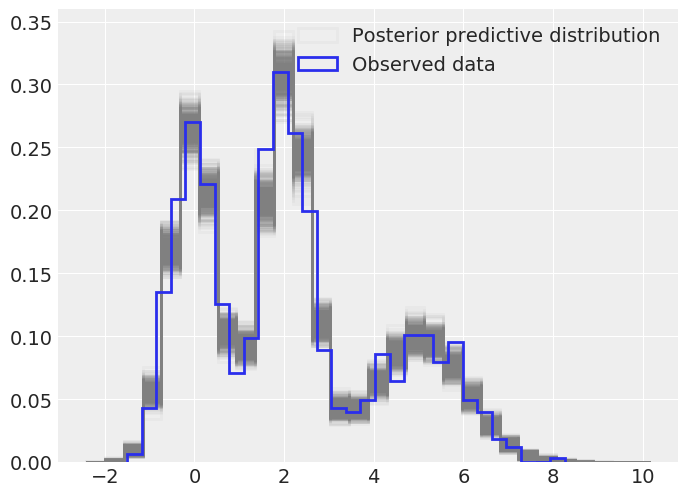

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [12]:
ppc_trace1['y'].shape

(5000, 1000)

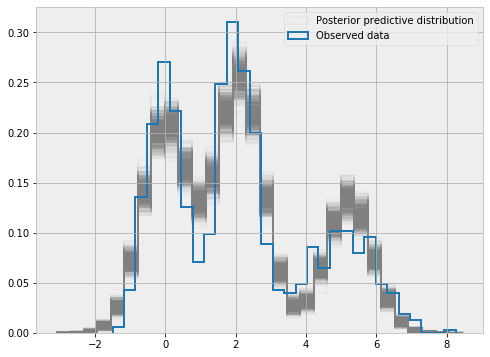

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ppc_trace1['y'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace1['y'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [8]:
traces=[trace,trace1]
models=["model","model1"]
compp=dict(zip(models,traces))
az.compare(compp)

NameError: name 'trace' is not defined

### Dependent density regression 相依密度回归
在另一个示例中，我们展示了如何使用Dirichlet过程执行贝叶斯非参数密度估计。 此示例在前一个示例的基础上进行了扩展，说明了依赖密度回归。

就像Dirichlet过程混合可以看作是选择活性成分数量作为推论的一部分的无限混合模型一样，依赖密度回归也可以看作是选择活性专家作为推论的一部分的专家的无限混合。 它们的灵活性和模块化使其成为执行非参数贝叶斯数据分析的强大工具。

In [107]:
plt.rc('animation', writer='ffmpeg')
blue, *_ = sns.color_palette()
SEED = 972915 # from random.org; for reproducibility
np.random.seed(SEED)
DATA_URI = 'http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat'

def standardize(x):
    return (x - x.mean()) / x.std()

df = (pd.read_csv(DATA_URI, sep=' *', engine='python')
        .assign(std_range=lambda df: standardize(df.range),
                std_logratio=lambda df: standardize(df.logratio)))

df.head()

C:\Users\zhaolei\Anaconda3\lib\site-packages\pandas\io\parsers.py:2420: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\zhaolei\Anaconda3\lib\site-packages\pandas\io\parsers.py:2423: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,range,logratio,std_range,std_logratio
0,390,-0.050356,-1.717725,0.852467
1,391,-0.060097,-1.707299,0.817981
2,393,-0.041901,-1.686447,0.882398
3,394,-0.050985,-1.676020,0.850240
4,396,-0.059913,-1.655168,0.818631


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


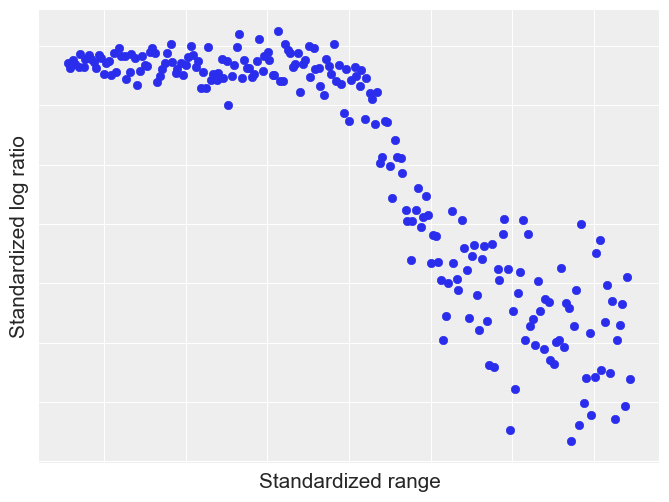

In [108]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.std_logratio,
           c=blue);

ax.set_xticklabels([]);
ax.set_xlabel("Standardized range");

ax.set_yticklabels([]);
ax.set_ylabel("Standardized log ratio");

该数据集有两个有趣的属性，可用于说明依赖密度回归。

范围和对数比之间的关系是非线性的，但是具有局部线性分量。

观察噪声是异方差的； 即，方差的大小随范围而变化。

依赖密度回归背后的直觉想法是将问题简化为许多（相关的）密度估计，其条件是预测变量的固定值。 以下动画说明了这种直觉。

In [109]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from matplotlib import animation as ani, pyplot as plt
import seaborn as sns
from theano import shared, tensor as tt

from IPython.display import HTML

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
fig, (scatter_ax, hist_ax) = plt.subplots(ncols=2, figsize=(16, 6))

scatter_ax.scatter(df.std_range, df.std_logratio,
                   c=blue, zorder=2);

scatter_ax.set_xticklabels([]);
scatter_ax.set_xlabel("Standardized range");

scatter_ax.set_yticklabels([]);
scatter_ax.set_ylabel("Standardized log ratio");

bins = np.linspace(df.std_range.min(), df.std_range.max(), 25)

hist_ax.hist(df.std_logratio, bins=bins,
             color='k', lw=0, alpha=0.25,
             label="All data");

hist_ax.set_xticklabels([]);
hist_ax.set_xlabel("Standardized log ratio");

hist_ax.set_yticklabels([]);
hist_ax.set_ylabel("Frequency");

hist_ax.legend(loc=2);

endpoints = np.linspace(1.05 * df.std_range.min(), 1.05 * df.std_range.max(), 15)

frame_artists = []

for low, high in zip(endpoints[:-1], endpoints[2:]):
    interval = scatter_ax.axvspan(low, high,
                                  color='k', alpha=0.5, lw=0, zorder=1);
    *_, bars = hist_ax.hist(df[df.std_range.between(low, high)].std_logratio,
                            bins=bins,
                            color='k', lw=0, alpha=0.5);

    frame_artists.append((interval,) + tuple(bars))

animation = ani.ArtistAnimation(fig, frame_artists,
                                interval=500, repeat_delay=3000, blit=True)
plt.close(); # prevent the intermediate figure from showing

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Running on PyMC3 v3.8


In [ ]:
HTML(animation.to_html5_video())

当我们使用沿左图在x轴上滑动的窗口对数据进行切片时，窗口中各点的y值的经验分布在右图中会发生变化。 该方法的一个重要方面是，对应于预测变量接近值的密度估计值相似。

在前面的示例中，我们看到Dirichlet过程将概率密度估计为具有无限多个分量的混合模型。 对于正态分量分布，

y∼∑i=1∞wi⋅N(μi,τ−1i),

混合权重w1，w2，…是通过折棍过程产生的。

相依密度回归通过允许混合物权重和成分均值根据预测变量x的条件而变化，来概括Dirichlet过程混合物模型的这种表示形式。 那是，

y | x∼∑i=1∞wi | x⋅N(μi | x,τ−1i).

在此示例中，我们将遵循贝叶斯数据分析的第23章，并使用概率折棍过程来确定条件混合权重wi |。 X。 打破概率的过程始于定义

vi | x=Φ(αi+βix),

其中Φ是标准正态分布的累积分布函数。 然后我们获得 x通过对vi应用折断过程| X。 那是，

wi | x=vi | x⋅∏j=1i−1(1−vj | x).

For the LIDAR data set, we use independent normal priors αi∼N(0,52) and βi∼N(0,52). We now express this this model for the conditional mixture weights using pymc3.

In [142]:
def norm_cdf(z):
    return 0.5 * (1 + tt.erf(z / np.sqrt(2)))  #Returns a variable representing the error function or the complementary error function. 

def stick_breaking(v):
    return v * tt.concatenate([tt.ones_like(v[:, :1]),
                               tt.extra_ops.cumprod(1 - v, axis=1)[:, :-1]],
                              axis=1)

In [143]:
N, _ = df.shape
K = 20

std_range = df.std_range.values[:, np.newaxis]
std_logratio = df.std_logratio.values[:, np.newaxis]

x_lidar = shared(std_range, broadcastable=(False, True))

with pm.Model() as model:
    alpha = pm.Normal('alpha', 0., 5., shape=K)
    beta = pm.Normal('beta', 0., 5., shape=K)
    v = norm_cdf(alpha + beta * x_lidar)
    w = pm.Deterministic('w', stick_breaking(v))

We have defined x_lidar as a theano `shared <http://deeplearning.net/software/theano/library/compile/shared.html>`__ variable in order to use pymc3’s posterior prediction capabilities later.

While the dependent density regression model theoretically has infinitely many components, we must truncate the model to finitely many components (in this case, twenty) in order to express it using pymc3. After sampling from the model, we will verify that truncation did not unduly influence our results.尽管从属密度回归模型在理论上具有无限多个组件，但为了使用pymc3进行表达，我们必须将模型截断为无限多个组件（在这种情况下为20个）。 从模型中采样后，我们将验证截断不会过度影响我们的结果。

Since the LIDAR data seems to have several linear components, we use the linear models

μi | xγiδi∼γi+δix∼N(0,102)∼N(0,102)
for the conditional component means.

In [144]:
with model:
    gamma = pm.Normal('gamma', 0., 10., shape=K)
    delta = pm.Normal('delta', 0., 10., shape=K)
    mu = pm.Deterministic('mu', gamma + delta * x_lidar)

Finally, we place the prior τi∼Gamma(1,1) on the component precisions.

In [145]:
with model:
    tau = pm.Gamma('tau', 1., 1., shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=tau, observed=std_logratio)

We now sample from the dependent density regression model.

In [114]:
SAMPLES = 20000
BURN = 10000

with model:
    step = pm.Metropolis()
    traceddr = pm.sample(SAMPLES, step, chains=1, tune=BURN, random_seed=SEED,cores=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [delta]
>Metropolis: [gamma]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling chain 0, 0 divergences: 100%|██████████████████████████████████████████| 30000/30000 [04:18<00:00, 115.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [146]:
with model:
    traceddr1 = pm.sample(10000, tune=5000, nuts_kwargs={'target_accept':0.85},init="adapt_diag",cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gof\opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  F

为了验证截断不会不适当地影响我们的结果，我们绘制了每种成分的最大后验预期混合重量。 （在此模型中，每个点对每个组件都有一个混合权重，因此我们在所有数据点上绘制每个组件的最大混合权重，以便判断该组件是否对后验施加任何影响。）

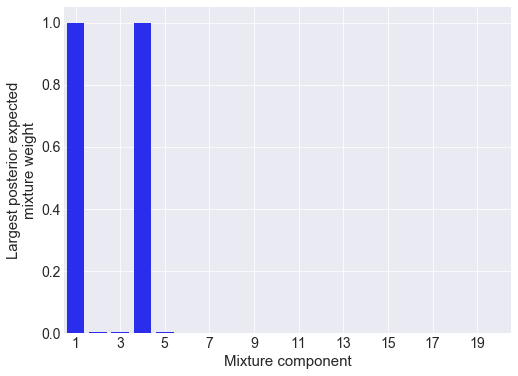

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(np.arange(K) + 1,
       traceddr['w'].mean(axis=0).max(axis=0));

ax.set_xlim(1 - 0.5, K + 0.5);
ax.set_xticks(np.arange(0, K, 2) + 1);
ax.set_xlabel('Mixture component');

ax.set_ylabel('Largest posterior expected\nmixture weight');

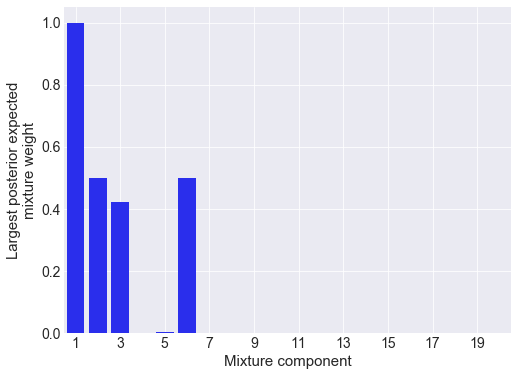

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(np.arange(K) + 1,
       traceddr1['w'].mean(axis=0).max(axis=0));

ax.set_xlim(1 - 0.5, K + 0.5);
ax.set_xticks(np.arange(0, K, 2) + 1);
ax.set_xlabel('Mixture component');

ax.set_ylabel('Largest posterior expected\nmixture weight');

由于对于任何数据点，只有三个混合物成分具有明显的后验预期重量，因此我们可以肯定的是，截断不会过度影响我们的结果。 （如果大多数组件的后部预期重量明显，截断可能会影响结果，我们将增加组件的数量并再次采样。）

在视觉上，LIDAR数据具有三个线性分量是合理的，因此这些后验预期权重似乎已经很好地识别了数据的结构。 现在，我们从后验预测分布中取样，以更好地了解模型的性能。

In [22]:
PP_SAMPLES = 1800

lidar_pp_x = np.linspace(std_range.min() - 0.05, std_range.max() + 0.05, 100)
x_lidar.set_value(lidar_pp_x[:, np.newaxis])

with model:
    pp_trace = pm.sample_posterior_predictive(traceddr, PP_SAMPLES, random_seed=SEED)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [21:33<00:00,  1.39it/s]


In [127]:
low, high = np.percentile(pp_trace['obs'], [2.5, 97.5], axis=0)
lidar_pp_x.shape

(100,)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


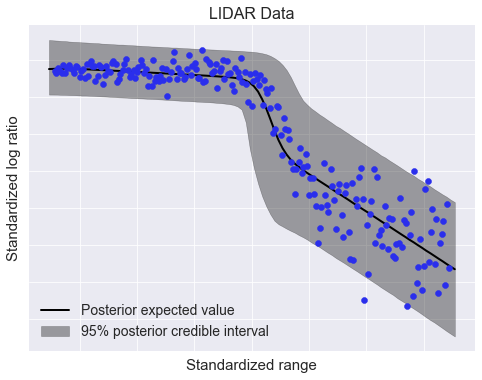

In [140]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.std_logratio,
           c=blue, zorder=10,
           label=None);

low, high = np.percentile(pp_trace['obs'], [2.5, 97.5], axis=0)
ax.fill_between(lidar_pp_x, low.T.mean(axis=1), high.T.mean(axis=1),
                color='k', alpha=0.35, zorder=5,
                label='95% posterior credible interval');

ax.plot(lidar_pp_x, pp_trace['obs'].mean(axis=0).T.mean(axis=1),
        c='k', zorder=6,
        label='Posterior expected value');

ax.set_xticklabels([]);
ax.set_xlabel('Standardized range');

ax.set_yticklabels([]);
ax.set_ylabel('Standardized log ratio');

ax.legend(loc='best');
ax.set_title('LIDAR Data');

该模型很好地拟合了数据的线性成分，并适应了其异方差性。 这种灵活性以及模块化指定条件混合权重和条件组分密度的能力，使得依赖密度回归成为极其有用的非参数贝叶斯模型。

要了解有关密度密度回归和相关模型的更多信息，请参阅贝叶斯数据分析，贝叶斯非参数数据分析或贝叶斯非参数。

### Gaussian Mixture Model with ADVI
在这里，我们描述了如何使用ADVI进行高斯混合模型的推断。 首先，我们将证明使用ADVI进行推理不需要修改随机模型，只需调用函数即可。 然后，我们将展示如何使用迷你批处理，这对于大型数据集很有用。 在这种情况下，应略微更改模型。

首先，从两个高斯分量的混合中创建人工数据。

env: THEANO_FLAGS=device=cpu,floatX=float32


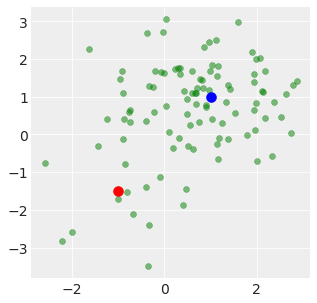

In [65]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

In [67]:
ms[0, 1]

-1.5

高斯混合模型通常由分类随机变量构成。 但是，任何离散的rv都不适合ADVI。 在这里，类分配变量被边缘化，给出高斯分量概率的加权和。 使用logsumexp计算总概率的对数似然，这是使这种计算稳定的标准技术。

在下面的代码中，DensityDist类用作似然项。 第二个参数logp_gmix（mus，pi，np.eye（2））是一个python函数，它接收观测值（以“值”表示）并返回对数似然的张量表示。

In [2]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


In [5]:
#For comparison with ADVI, run MCMC.
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start,cores=1)

logp = -384.33, ||grad|| = 62.173: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 445.70it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:01<00:00, 815.18it/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


查组件均值和权重的后验。 我们可以看到，由于这些聚类的样本大小不同，左下成分的均值MCMC样本比右上成分的变化更大。

(-6, 6)

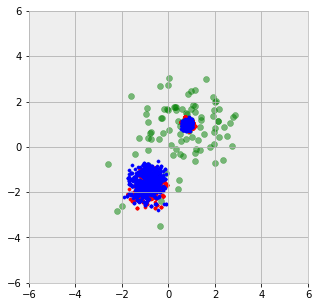

In [6]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[:, 0], mu_0[:, 1], c="r", s=10)
plt.scatter(mu_1[:, 0], mu_1[:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

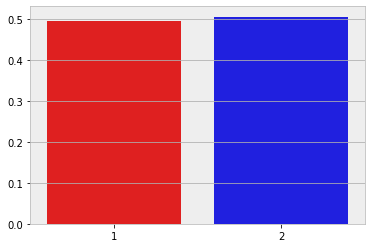

In [7]:
sns.barplot([1, 2], np.mean(trace['pi'][:], axis=0),
            palette=['red', 'blue'])

In [8]:
## We can use the same model with ADVI as follows.
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 323.96: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:04<00:00, 990.13it/s]
Finished [100%]: Average Loss = 323.95


Wall time: 1min 17s


C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


该函数返回三个变量。 “均值”和“ sds”是变异后验的均值和标准偏差。 请注意，这些值在转换后的空间中，而不是在原始空间中。 对于实线上的随机变量，例如，高斯分量的均值，不应用任何变换。 然后我们可以看到原始空间中的后验变化。

(-6, 6)

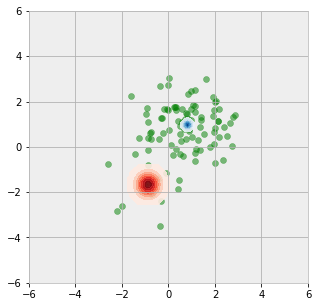

In [9]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

待办事项：我们需要向后转换由stick_breaking转换的pi。

“ elbos”包含ELBO的踪迹，表明该算法是随机收敛的。

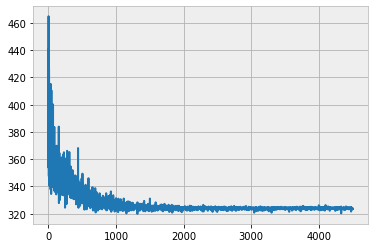

In [10]:
plt.plot(approx.hist)

为了证明ADVI适用于带有小批量的大型数据集，让我们从相同的混合物分布中创建100,000个样本。

(-6, 6)

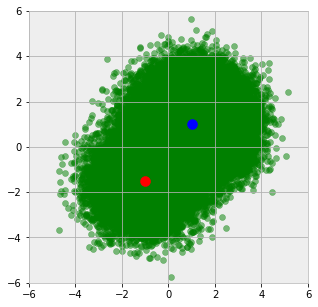

In [11]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [12]:
#MCMC took 55 seconds, 20 times longer than the small dataset.
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start,cores=1)

logp = -3.6535e+05, ||grad|| = 0.0040229: 100%|████████████████████████████████████████| 44/44 [00:01<00:00, 22.85it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 1500/1500 [02:59<00:00,  8.36it/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(-6, 6)

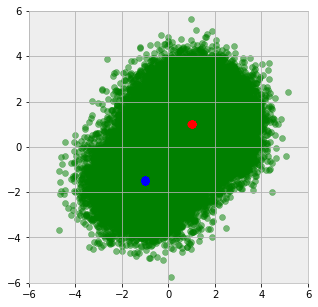

In [13]:
#Posterior samples are concentrated on the true means, so looks like single point for each component.
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=50)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

对于具有小批量的ADVI，将theano张量放在ObservedRV的观测变量上。 张量将替换为迷你批。 由于小批量样品和整个样品的大小不同，对数似然项应适当缩放。 为了说明对数似然项，我们需要给放置微型批处理的ObservedRV对象（下面的“ minibatch_RVs”）赋值。 另外，我们应该保留张量（'minibatch_tensors'）。

In [14]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [15]:
# Used only to write the function call in single line for using %time
# is there more smart way?
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 651.27: 100%|██████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 922.71it/s]
Finished [100%]: Average Loss = 651.19


Wall time: 35 s


(-6, 6)

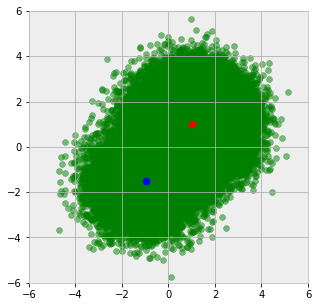

In [16]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plt.scatter(mu_0[0], mu_0[1], c="r", s=50)
plt.scatter(mu_1[0], mu_1[1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

由于从整个样本中进行了二次采样，因此ELBO的迹线方差比没有小批量处理时的方差大。

In [ ]:
plt.plot(elbos);

## Repeat exercise 1 using a Dirichlet process.

In [31]:
vals1=(vals-vals.mean())/vals.std()

In [32]:
K=20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [33]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(vals1.min(), vals1.max(), K),
                      sd=1, shape=K)
    sd = pm.HalfNormal('sd', sd=1, shape=K)
    
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=vals1)
    tracedp = pm.sample(10000, tune=5000, nuts_kwargs={'target_accept':0.9},init="adapt_diag",cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, β, α]
Sampling chain 1, 731 divergences: 100%|█████████████████████████████████████████| 15000/15000 [15:36<00:00, 16.01it/s]
There were 805 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1536 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


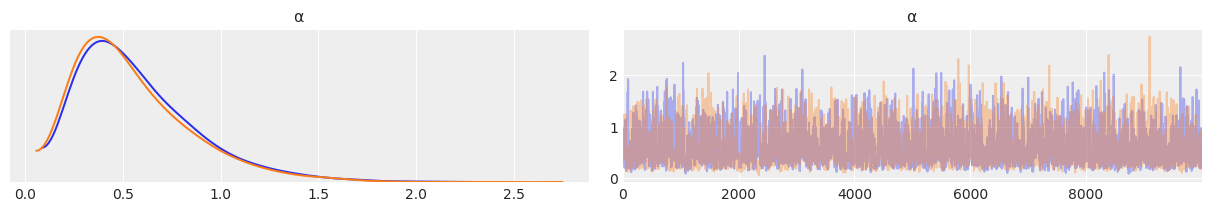

In [34]:
az.plot_trace(tracedp, var_names=['α'], divergences=False);

In [37]:
az.plot_trace(tracedp, var_names=['w', 'means'], divergences=False);
#pm.traceplot(tracedp, var_names=['w', 'means']);

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

Error in callback <function flush_figures at 0x0000020C556DFA60> (for post_execute):


KeyboardInterrupt: 

Text(0, 0.5, 'Average weight')

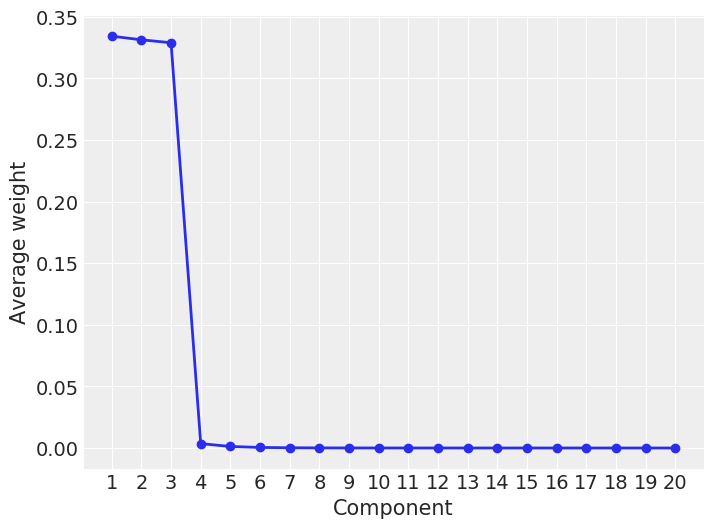

In [35]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, tracedp['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')

([], <a list of 0 Text yticklabel objects>)

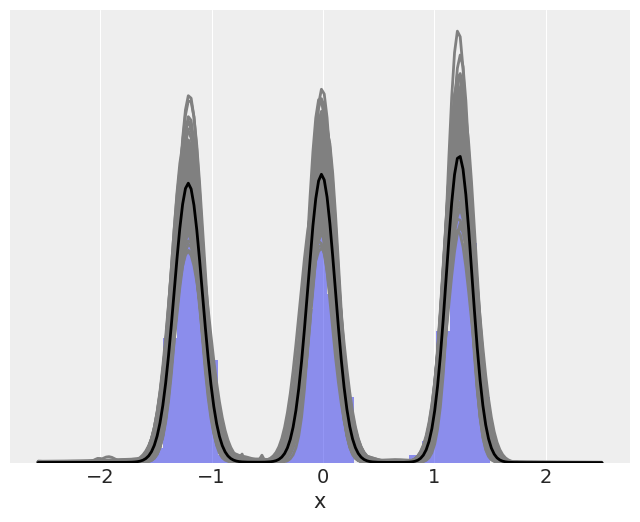

In [36]:
x_plot = np.linspace(vals1.min()-1, vals1.max()+1, 200)

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   tracedp['means'][:, np.newaxis, :],
                                   tracedp['sd'][:, np.newaxis, :])
post_pdfs = (tracedp['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

plt.figure(figsize=(8, 6))

plt.hist(vals1, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')

plt.xlabel('x')
plt.yticks([])

Assuming for a moment that you do not know the correct species/labels
for the Iris dataset, use a mixture model to cluster the three iris species,
using one feature of your choice (like the length of the sepal).

In [35]:
iris = pd.read_csv('../data/iris.csv')
sepal_length = iris["sepal_length"].values

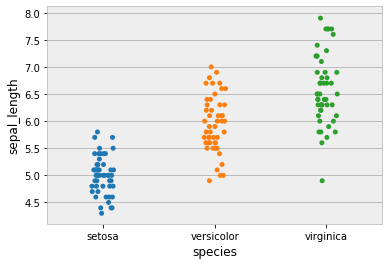

In [36]:
import seaborn as sns
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)  #分类散点图

In [40]:
sepal_trace['means'].mean(axis=0)

array([5.304428 , 6.1029487, 7.6707892], dtype=float32)

In [38]:
clusters = 3
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.linspace(sepal_length.min(), sepal_length.max(), clusters), sd=10, 
                      shape=clusters, transform=pm.distributions.transforms.ordered)
    
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=sepal_length)
    sepal_trace = pm.sample(5000, tune=2000,cores=1,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
Sampling chain 1, 2 divergences: 100%|█████████████████████████████████████████████| 7000/7000 [01:22<00:00, 84.97it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002140713C438>,
      dtype=object)

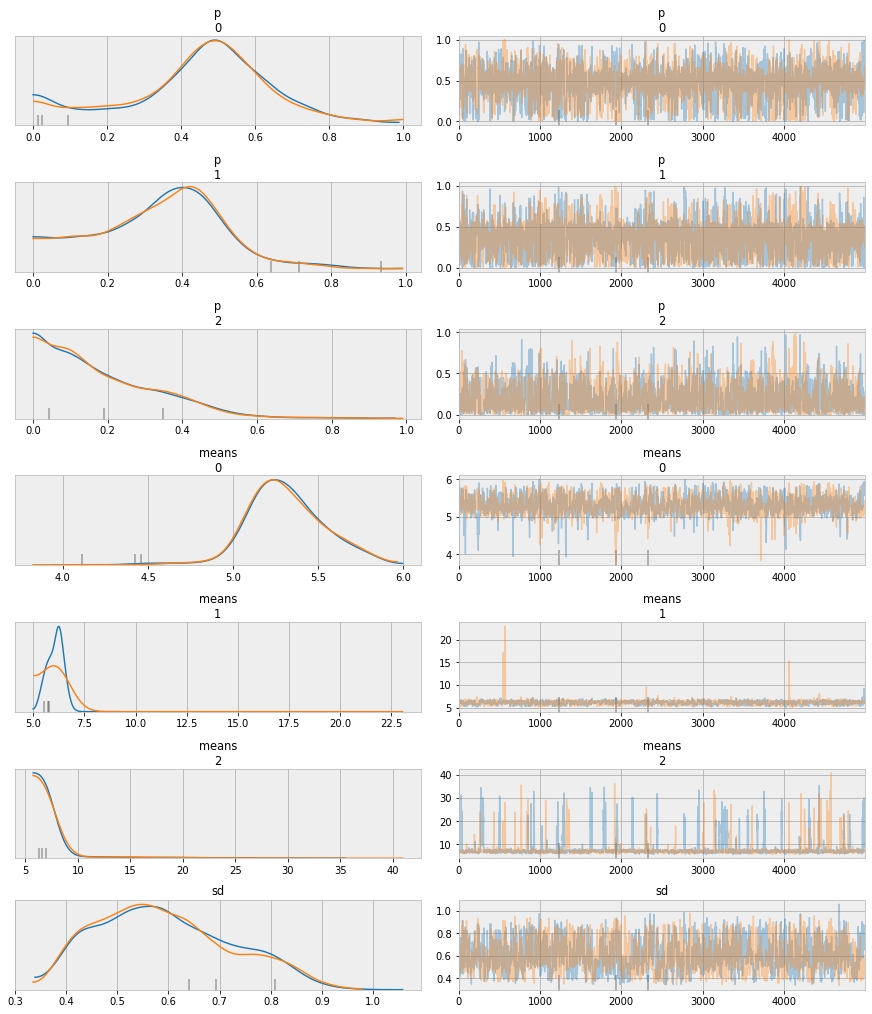

In [39]:
az.plot_trace(sepal_trace)

In [42]:
az.summary(sepal_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.456,0.198,0.000,0.743,0.006,0.004,1186.0,1186.0,1270.0,1091.0,1.0
p[1],0.357,0.187,0.000,0.655,0.004,0.003,2496.0,2011.0,2530.0,1927.0,1.0
p[2],0.187,0.156,0.000,0.453,0.004,0.003,1231.0,1231.0,1049.0,1172.0,1.0
means[0],5.304,0.236,4.979,5.802,0.007,0.005,1130.0,1128.0,1109.0,1661.0,1.0
means[1],6.103,0.544,5.352,6.692,0.018,0.013,908.0,908.0,971.0,1473.0,1.0
means[2],7.671,3.143,5.762,11.842,0.112,0.079,790.0,790.0,894.0,870.0,1.0
sd,0.593,0.129,0.386,0.837,0.005,0.004,604.0,604.0,592.0,2020.0,1.0


In [43]:
az.loo(sepal_trace)

Computed from 10000 by 150 log-likelihood matrix

         Estimate       SE
elpd_loo  -184.92     6.84
p_loo        4.13        -

Repeat exercise 5 but this time use two features.

In [44]:
iris = pd.read_csv('../data/iris.csv')
sepal_length = iris["sepal_length"].values
petal_width = iris["petal_width"].values

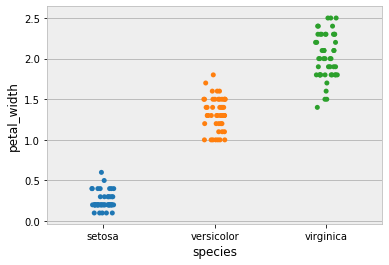

In [45]:
sns.stripplot(x="species", y="petal_width", data=iris, jitter=True)  #分类散点图

In [46]:
clusters = 3
with pm.Model() as model_mg:
    # Sepal Width
    p_petal_width = pm.Dirichlet('p_petal_width', a=np.ones(clusters))
    means_petal_width = pm.Normal('means_petal_width', mu=np.linspace(petal_width.min(), petal_width.max(), clusters), sd=10, 
                      shape=clusters, transform=pm.distributions.transforms.ordered)
    sd_petal_width = pm.HalfNormal('sd_petal_width', sd=1)
    petal_width_y = pm.NormalMixture('petal_width_y', w=p_petal_width, mu=means_petal_width, sd=sd_petal_width, observed=petal_width)
    
    # Sepal length
    p_sepal_length = pm.Dirichlet('p_sepal_length', a=np.ones(clusters))
    means_sepal_length = pm.Normal('means_sepal_length', mu=np.linspace(sepal_length.min(), sepal_length.max(), clusters), sd=10, 
                      shape=clusters, transform=pm.distributions.transforms.ordered)
    sd_sepal_length = pm.HalfNormal('sd_sepal_length', sd=1)
    sepal_length_y = pm.NormalMixture('sepal_length_y', w=p_sepal_length, mu=means_sepal_length, sd=sd_sepal_length, observed=sepal_length)
    
    
    sepal_length_width_trace = pm.sample(5000, tune=2000,cores=1,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_sepal_length, means_sepal_length, p_sepal_length, sd_petal_width, means_petal_width, p_petal_width]
Sampling chain 1, 6 divergences: 100%|█████████████████████████████████████████████| 7000/7000 [03:08<00:00, 37.11it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021476888D68>,
      dtype=object)

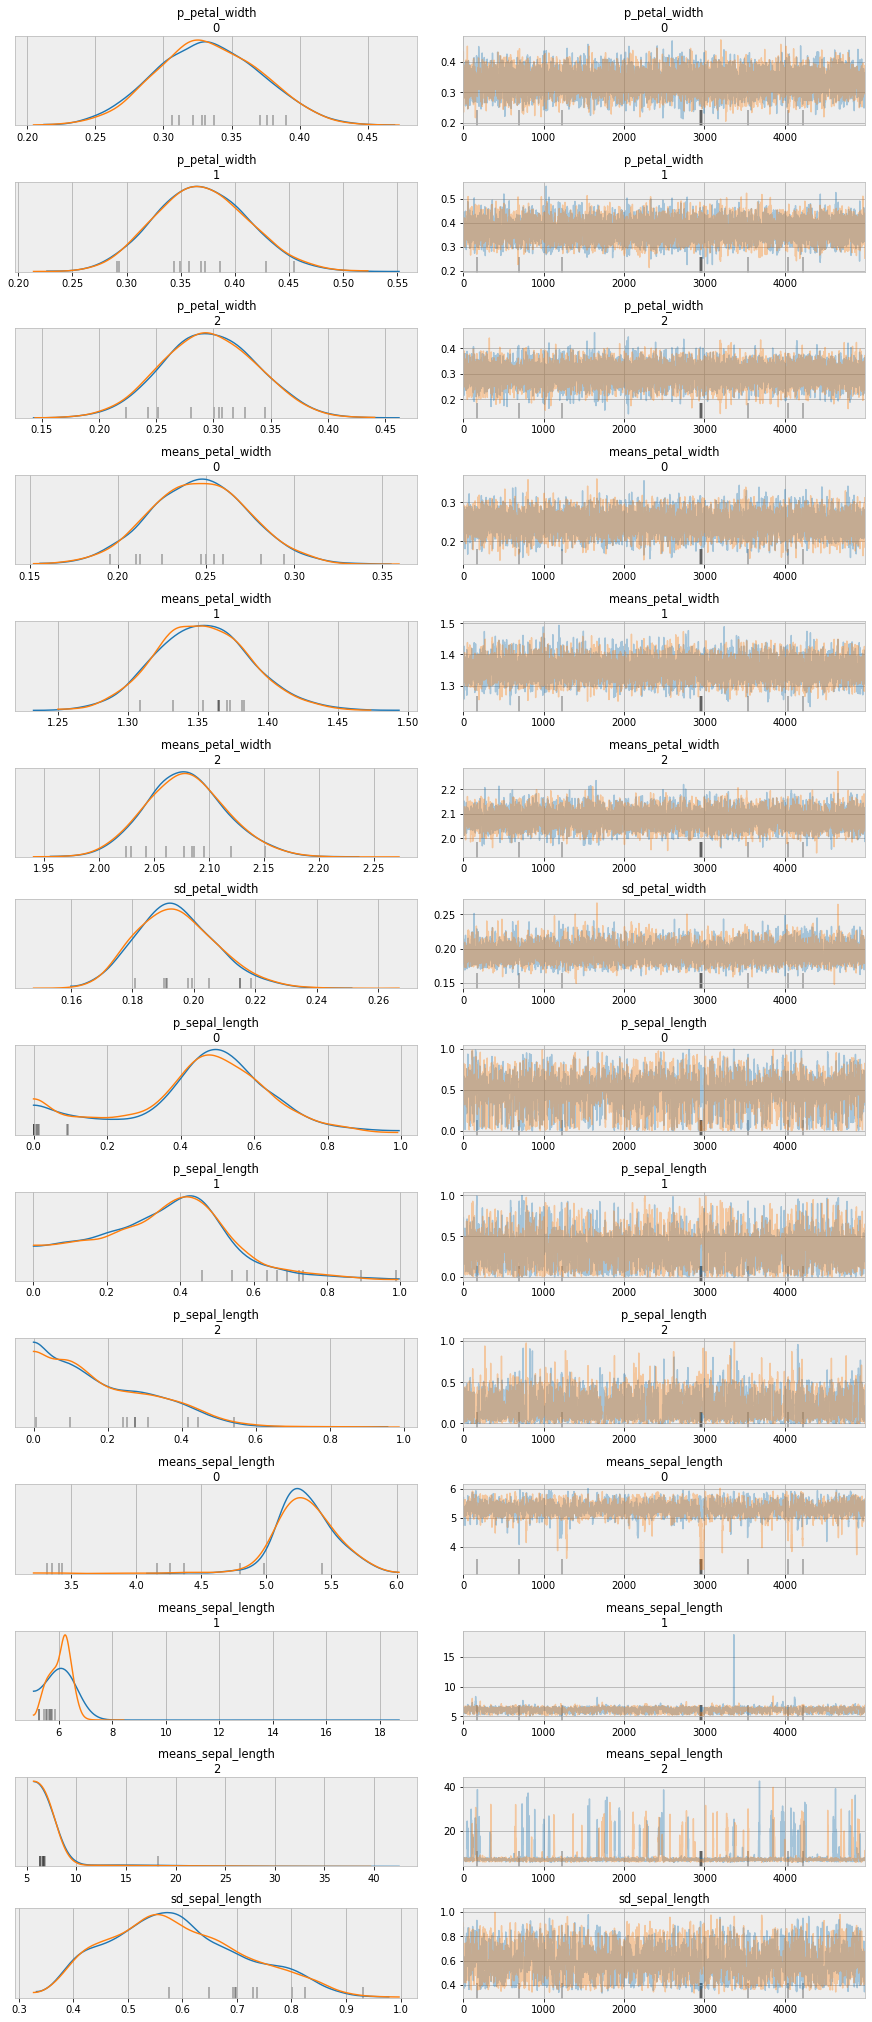

In [47]:
az.plot_trace(sepal_length_width_trace)

In [55]:
az.waic(sepal_length_width_trace)

TypeError: Found several log likelihood arrays ['petal_width_y', 'sepal_length_y'], var_name cannot be None

In [51]:
az.summary(sepal_length_width_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p_petal_width[0],0.333,0.038,0.267,0.409,0.000,0.000,9023.0,9023.0,9008.0,6933.0,1.0
p_petal_width[1],0.370,0.043,0.288,0.447,0.000,0.000,9016.0,8900.0,9019.0,6934.0,1.0
p_petal_width[2],0.297,0.041,0.225,0.378,0.000,0.000,9252.0,9252.0,9198.0,5788.0,1.0
means_petal_width[0],0.246,0.028,0.196,0.300,0.000,0.000,6223.0,6156.0,6228.0,6518.0,1.0
means_petal_width[1],1.354,0.034,1.291,1.419,0.000,0.000,7500.0,7481.0,7542.0,7829.0,1.0
means_petal_width[2],2.079,0.036,2.010,2.148,0.000,0.000,10963.0,10925.0,11086.0,8079.0,1.0
sd_petal_width,0.194,0.013,0.170,0.218,0.000,0.000,6411.0,6294.0,6638.0,6070.0,1.0
p_sepal_length[0],0.454,0.202,0.000,0.737,0.005,0.004,1623.0,1623.0,1566.0,887.0,1.0
p_sepal_length[1],0.354,0.184,0.000,0.640,0.003,0.002,3457.0,3079.0,3483.0,2892.0,1.0
p_sepal_length[2],0.192,0.154,0.000,0.448,0.004,0.003,1658.0,1658.0,1239.0,1297.0,1.0
